# preprocess

In [3]:
import anndata as ad
import numpy as np
import scanpy as sc
import pandas as pd
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from scipy.optimize import linear_sum_assignment

import sys
sys.path.append('../..')
from src.interface import UnitedNet
from src.configs import *
from src.data import partitions,save_umap,generate_adata,patch_seq_pre_ps
from src.scripts import ordered_cmat,assignmene_align
import copy as copy


from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score,adjusted_rand_score

import shap
import torch
import torch.nn as nn
from src.modules import submodel_trans, submodel_clus
from src.data import save_obj, load_obj, partitions, type_specific_mean
from src.plots import markers_chord_plot,type_relevance_chord_plot,feature_relevance_chord_plot,merge_sub_feature,merge_sub_feature_all



In [4]:
technique = 'patchseq'
data_path = f"../../data/{technique}"
device = "cuda:0"
# device = "cpu"
root_save_path = f"../../saved_results/{technique}"
#load data
adata_rna_raw = sc.read_h5ad(f'{data_path}/adata_RNA_TEM.h5ad')
adata_ephys_raw = sc.read_h5ad(f'{data_path}/adata_Ephys_TEM.h5ad')
adata_morph_raw = sc.read_h5ad(f'{data_path}/adata_Morph_TEM.h5ad')
ind_dict = partitions(adata_rna_raw.obs['cell_type_TEM'], n_partitions=10, seed=0)


# patch-seq data adaptive weight

In [ ]:
train = False
for cv in range(9,10):
    root_save_path = f"./saved_results/{technique}_{cv}_n"
    model = UnitedNet(root_save_path, device=device, technique=patchseq_config)
    _,_,adatas_all = patch_seq_pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,ind_dict,split=False)

In [ ]:
if train:
    for cv in range(10):
        adatas_train,adatas_test,_ = patch_seq_pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,ind_dict,split=True)
        root_save_path = f"./saved_results/{technique}_{cv}_n"
        model = UnitedNet(root_save_path, device=device, technique=patchseq_config)
        model.train(adatas_train,adatas_val = adatas_test)

        print(model.evaluate(adatas_test))
        _,_,adatas_all = patch_seq_pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,ind_dict,split=False)
        model.load_model(f"{root_save_path}/train_best.pt")
        model.model.config['train_task'] = "unsupervised_group_identification"
        model.model.config['train_epochs'] = 20
        model.train(adatas_all,verbose=True,init_classify=True)
else:
    for cv in range(10):
        root_save_path = f"./saved_results/{technique}_{cv}_n"
        model = UnitedNet(root_save_path, device=device, technique=patchseq_config)
        _,_,adatas_all = patch_seq_pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,ind_dict,split=False)


training


100%|██████████| 20/20 [00:50<00:00,  2.52s/it]


{'r2': array([[0.19399887, 0.13683871, 0.05519542],
       [0.26283035, 0.61584647, 0.10837105],
       [0.09798893, 0.02486651, 0.47516435]]), 'confusion': array([[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0

  0%|          | 0/20 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
ddc_loss_head_0            0.150935
ddc_loss_head_2            0.148747
ddc_loss_head_9            0.152016
ddc_loss_head_8            0.148033
self_entropy_loss_head_1  -0.0315719
self_entropy_loss_head_0  -0.0315741
self_entropy_loss_head_4  -0.0314347
self_entropy_loss_head_2  -0.0317708
self_entropy_loss_head_9  -0.0315204
reconstruction_loss        0.569154
self_entropy_loss_head_5  -0.031544
self_entropy_loss_head_3  -0.0314612
ddc_loss_head_4            0.148728
self_entropy_loss_head_6  -0.0316453
self_entropy_loss_head_7  -0.0314447
ddc_loss_head_5            0.148704
ddc_loss_head_6            0.150025
ddc_loss_head_7            0.147802
self_entropy_loss_head_8  -0.031387
ddc_loss_head_1            0.148572
ddc_loss_head_3            0.149113
best_head                  7
best model saved at ./saved_results/patchseq_1_n/train_best.pt 

model saved at ./saved_results/patchseq_1_n/train_epoch_1.pt 



  5%|▌         | 1/20 [00:03<01:13,  3.88s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.19842334 0.17937903 0.14878894]
            [0.40977765 0.62056721 0.29062052]
            [0.24868829 0.21026244 0.44476692]]
confusion  [[40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  0 11  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  0  2  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 6  1  0  7  0 21  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 10%|█         | 2/20 [00:07<01:07,  3.78s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2166831  0.19296623 0.17308492]
            [0.45533974 0.67155567 0.35242903]
            [0.30119174 0.26626609 0.48720239]]
confusion  [[20 20  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 10 11  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3
              1  0  0]
            [ 0  0  2  1  3  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
              0  0  0]
            [ 0  0  8  3  0 14  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  9
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 15%|█▌        | 3/20 [00:11<01:04,  3.77s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.23288921 0.21283344 0.19495462]
            [0.47106901 0.70882438 0.3901533 ]
            [0.33139271 0.29739096 0.51700716]]
confusion  [[22  0  0  0  0  0 18  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  4 17  5  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              3  0  0]
            [ 0  0  4  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  7  4  9 12  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  0  0  1  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0

 20%|██        | 4/20 [00:15<01:00,  3.76s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.24903052 0.22831557 0.21461231]
            [0.51729307 0.73862363 0.43182088]
            [0.36177922 0.32993416 0.53409719]]
confusion  [[22 18  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  4 10  6  0  0  0  0  0  0  0  2  0  0  1  0  0  0  0  0  0  0  0
              7  0  0]
            [ 0  0  2  2  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  1  2 10 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              4  0  0]
            [ 1  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 25%|██▌       | 5/20 [00:18<00:56,  3.76s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.25663705 0.23917659 0.22733154]
            [0.52999504 0.74925026 0.4583021 ]
            [0.38504448 0.35796158 0.55930336]]
confusion  [[23 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              3  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  7 10  5  0  0  0  7  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  3  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  6  2  6 21  0  0  1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 30%|███       | 6/20 [00:22<00:53,  3.80s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27080737 0.25642871 0.23291123]
            [0.54731811 0.77078169 0.48039139]
            [0.40588566 0.38520485 0.57813376]]
confusion  [[20 20  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4 18  2  0  2  0  1  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  2  2  1  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  7 23  2  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  1  0

 35%|███▌      | 7/20 [00:26<00:49,  3.80s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28972665 0.27188439 0.26069546]
            [0.59041332 0.79890108 0.53623268]
            [0.43703891 0.43043648 0.59414937]]
confusion  [[20 19  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3 18  3  1  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  2  2  2  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  2  2 27  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
              0  0  0

 40%|████      | 8/20 [00:30<00:45,  3.82s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30022535 0.28525515 0.26702573]
            [0.62291693 0.81903172 0.55800208]
            [0.45596351 0.46312726 0.61448327]]
confusion  [[26 14  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  2 19  3  0  0  0  4  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  2  2  1  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  2 26  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0
              0  0  0

 45%|████▌     | 9/20 [00:34<00:41,  3.81s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30748974 0.29664982 0.28671808]
            [0.62461867 0.82407823 0.58968292]
            [0.47641667 0.48105258 0.62934807]]
confusion  [[22  0  0  0  0  0  2  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4 22  1  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  2  1  0  0  0  0  0  0  1  0  2  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  9  2  1 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
              0  0  0

 50%|█████     | 10/20 [00:37<00:37,  3.77s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.31745634 0.31218335 0.30052475]
            [0.63838809 0.82612739 0.60711213]
            [0.49065562 0.48585765 0.64098236]]
confusion  [[24  0  0  0  0  0  3  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0 23  4  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  3  2  1  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  1 11 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  2  0

 55%|█████▌    | 11/20 [00:41<00:34,  3.78s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.34123427 0.33242305 0.31917824]
            [0.66575844 0.84993564 0.64565235]
            [0.51378787 0.524552   0.66075306]]
confusion  [[29  3  0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  1  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4 16  8  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  2  2  1  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  9  6  1 18  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 60%|██████    | 12/20 [00:45<00:30,  3.77s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.35418546 0.35141632 0.33509822]
            [0.6777126  0.86044386 0.66007703]
            [0.53286091 0.56219799 0.67358722]]
confusion  [[25  0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3 16  8  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  2  2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 10  1  6 18  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 65%|██████▌   | 13/20 [00:49<00:26,  3.76s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.366258   0.36861087 0.35727757]
            [0.70650763 0.86997652 0.68293296]
            [0.55038209 0.58541172 0.69662049]]
confusion  [[38  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  6 17  5  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  2  2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 11  1  6 19  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 70%|███████   | 14/20 [00:52<00:22,  3.75s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.37676831 0.37020566 0.35254138]
            [0.72348668 0.87761032 0.70375147]
            [0.57931075 0.61134494 0.71088198]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5 20  2  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  3  1  2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  9  1  6 20  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 75%|███████▌  | 15/20 [00:56<00:18,  3.77s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.40085378 0.40320041 0.38588896]
            [0.74368001 0.89182878 0.72597537]
            [0.59939617 0.6355362  0.723437  ]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4 22  1  0  2  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  4  1  2  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 10  1  6 20  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 80%|████████  | 16/20 [01:00<00:15,  3.78s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.42026833 0.4248528  0.40701424]
            [0.7496043  0.9031977  0.75010934]
            [0.61456653 0.6609739  0.73672051]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1 21  4  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  2  3  1  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  6  1  9 20  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 85%|████████▌ | 17/20 [01:04<00:11,  3.90s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.43459944 0.44183305 0.42003014]
            [0.7620679  0.90689912 0.75364487]
            [0.61980577 0.65603966 0.72591546]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 21  3  0  2  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  2  2  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  9 20  1  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 90%|█████████ | 18/20 [01:08<00:07,  3.86s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.45296231 0.4585499  0.43912057]
            [0.78707347 0.91270461 0.7747364 ]
            [0.63982513 0.69749474 0.75849528]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4 20  3  0  2  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  3  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  7  1  7 20  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 95%|█████████▌| 19/20 [01:12<00:03,  3.86s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.47177918 0.4729097  0.45674663]
            [0.79900774 0.91531127 0.80044719]
            [0.65287222 0.7188325  0.77502489]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2 24  1  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  4  1  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 12  1  7 15  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

100%|██████████| 20/20 [01:16<00:00,  3.81s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.49268409 0.49936816 0.47751134]
            [0.812072   0.91979657 0.82108457]
            [0.68691341 0.73547151 0.79304052]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 23  2  0  2  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  2  2  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
              0  1  0]
            [ 0  0  0  1 14 16  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

training


100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


{'r2': array([[0.21180572, 0.14774969, 0.1062541 ],
       [0.32629432, 0.65566003, 0.10668195],
       [0.16810577, 0.15325067, 0.50332448]]), 'confusion': array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0

  0%|          | 0/20 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
ddc_loss_head_0            0.150544
ddc_loss_head_2            0.149448
ddc_loss_head_9            0.149161
ddc_loss_head_8            0.149633
self_entropy_loss_head_1  -0.0315191
self_entropy_loss_head_0  -0.0314295
self_entropy_loss_head_4  -0.0316164
self_entropy_loss_head_2  -0.0316251
self_entropy_loss_head_9  -0.0315037
reconstruction_loss        0.46846
self_entropy_loss_head_5  -0.0315743
self_entropy_loss_head_3  -0.0316598
ddc_loss_head_4            0.147366
self_entropy_loss_head_6  -0.0314748
self_entropy_loss_head_7  -0.0314705
ddc_loss_head_5            0.149577
ddc_loss_head_6            0.148701
ddc_loss_head_7            0.150234
self_entropy_loss_head_8  -0.031526
ddc_loss_head_1            0.149423
ddc_loss_head_3            0.15061
best_head                  4
best model saved at ./saved_results/patchseq_2_n/train_best.pt 

model saved at ./saved_results/patchseq_2_n/train_epoch_1.pt 



  5%|▌         | 1/20 [00:03<01:11,  3.75s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26618652 0.24338384 0.21975768]
            [0.55265638 0.74766607 0.44479176]
            [0.40246808 0.36578994 0.55186711]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  9  1  3  0  0  0  0  0  0 10  6  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  2  2  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  0  9  0 10  0  0  0  0  0  0  3  0 15  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 10%|█         | 2/20 [00:07<01:07,  3.76s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28062684 0.26179384 0.24433811]
            [0.58117943 0.79730178 0.50263501]
            [0.42522169 0.41569988 0.5745535 ]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2 27  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  5  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  6  0 22  0  0  0  0  0  0  0  0  6  0  0  0  0  0  4  0  0  0
              0  0  0]
            [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0
              0  0  0

 15%|█▌        | 3/20 [00:11<01:04,  3.77s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29517547 0.27434006 0.26412693]
            [0.62063383 0.82498782 0.54072687]
            [0.45460454 0.44530061 0.60118086]]
confusion  [[26  0  0  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0 13  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  8 18  0  0  2  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  2  1  1  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  2  4  5 23  1  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 20%|██        | 4/20 [00:15<00:59,  3.75s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30413155 0.28508564 0.27950424]
            [0.6272789  0.81568178 0.57025777]
            [0.4782051  0.47976497 0.61358103]]
confusion  [[36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              5  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  7 17  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
              0  0  0]
            [ 0  0  0  5  3  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  1  3 11 18  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 25%|██▌       | 5/20 [00:18<00:56,  3.75s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.31614902 0.30191632 0.29145531]
            [0.65267319 0.84050546 0.59501946]
            [0.500598   0.50054137 0.64481271]]
confusion  [[35  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              6  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 10 16  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  2  0 10 17  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 30%|███       | 6/20 [00:23<00:55,  3.93s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.32695245 0.3102454  0.30837802]
            [0.68397632 0.85551195 0.63792805]
            [0.52376774 0.51961346 0.66483993]]
confusion  [[36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  7 16  6  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  5  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0 11 12  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0
              3  0  0]
            [ 0  0  0  0  0  1  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 35%|███▌      | 7/20 [00:26<00:50,  3.88s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.34272351 0.33056021 0.32031473]
            [0.71012768 0.87002976 0.65770345]
            [0.54544019 0.56446811 0.68082619]]
confusion  [[30  0  0  0  0  0  0  0  2  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              8  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 11 13  5  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0 10 19  0  0  0  0  0  1  0  0  6  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 40%|████      | 8/20 [00:30<00:46,  3.85s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.35787101 0.34418056 0.32986379]
            [0.71596605 0.87081925 0.66219579]
            [0.55769692 0.57371237 0.6731274 ]]
confusion  [[31  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              5  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  7 17  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0 14 15  0  0  0  0  0  1  0  0  6  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 45%|████▌     | 9/20 [00:34<00:42,  3.83s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.36564753 0.35866048 0.34478725]
            [0.73150785 0.88032765 0.68856743]
            [0.57334514 0.59335661 0.69470633]]
confusion  [[38  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  7 17  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  5  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0 11 20  0  0  0  0  0  1  0  0  5  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 50%|█████     | 10/20 [00:38<00:38,  3.82s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.38542212 0.3803167  0.36571114]
            [0.74407437 0.88792434 0.71212262]
            [0.59955886 0.62480313 0.71974976]]
confusion  [[36  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5 18  6  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  3  2  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  9 22  0  0  0  0  0  1  0  0  4  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 55%|█████▌    | 11/20 [00:41<00:34,  3.80s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.40928934 0.39975512 0.37864186]
            [0.77194737 0.90331445 0.71214822]
            [0.61914793 0.63630869 0.72963391]]
confusion  [[38  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 10 15  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  3  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  9 22  0  0  0  0  0  1  0  0  4  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 60%|██████    | 12/20 [00:45<00:30,  3.80s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.41692217 0.41322037 0.39367271]
            [0.78575524 0.90821544 0.75034908]
            [0.63434579 0.67206333 0.73296211]]
confusion  [[31  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 11 13  5  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  2  4  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  7 28  0  0  0  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 65%|██████▌   | 13/20 [00:49<00:26,  3.79s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.44106127 0.43974083 0.41795204]
            [0.79417385 0.90963089 0.76588447]
            [0.65649244 0.69510807 0.75522045]]
confusion  [[38  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 10 12  7  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  2  4  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  6 29  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 70%|███████   | 14/20 [00:53<00:22,  3.78s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.46185898 0.45910966 0.43379164]
            [0.80897867 0.91100059 0.76829392]
            [0.66919339 0.72066939 0.75951735]]
confusion  [[39  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 13 12  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  1  2  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  5 29  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 75%|███████▌  | 15/20 [00:57<00:18,  3.79s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.47817583 0.48249604 0.46146633]
            [0.80862364 0.92154451 0.79968736]
            [0.68762801 0.73818874 0.78713741]]
confusion  [[37  0  0  0  0  0  3  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 11 15  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  2  2  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  0  5 26  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 80%|████████  | 16/20 [01:00<00:15,  3.82s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.49523325 0.49754554 0.4783706 ]
            [0.81433915 0.92791771 0.80562536]
            [0.69121509 0.74266028 0.78945232]]
confusion  [[38  0  0  0  0  0  0  0  1  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  6 16  6  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  1  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  2  0  8 20  0  0  0  0  0  1  0  0  6  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 85%|████████▌ | 17/20 [01:04<00:11,  3.80s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.5183098  0.52015364 0.4939924 ]
            [0.83520185 0.92822805 0.82296643]
            [0.71404655 0.76669673 0.8020953 ]]
confusion  [[40  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  8 15  4  2  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  1  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  6 26  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 90%|█████████ | 18/20 [01:08<00:07,  3.84s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.53359713 0.53566402 0.51557128]
            [0.84676035 0.93385955 0.83367394]
            [0.73328699 0.77043548 0.81187299]]
confusion  [[40  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  9 14  4  2  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  1  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  7 22  0  0  4  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 95%|█████████▌| 19/20 [01:12<00:03,  3.80s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.55147633 0.55892009 0.5383814 ]
            [0.85305576 0.93551992 0.85253534]
            [0.74907204 0.78743867 0.82983617]]
confusion  [[37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0
              2  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  6 16  3  4  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  2  1  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  2  0  6 16  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
             12  0  0]
            [ 0  0  1  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

100%|██████████| 20/20 [01:16<00:00,  3.81s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.57090839 0.57435236 0.5605068 ]
            [0.85839111 0.93781275 0.86449977]
            [0.7618625  0.8003811  0.83714523]]
confusion  [[37  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  8 14  2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              5  0  0]
            [ 0  0  1  1  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              2  0  0]
            [ 1  0  1  0 15 13  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              7  0  0]
            [ 0  0  1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

training


100%|██████████| 20/20 [00:51<00:00,  2.56s/it]


{'r2': array([[0.21595356, 0.13413032, 0.10869977],
       [0.26669304, 0.67710238, 0.13801905],
       [0.16635774, 0.05537481, 0.4910246 ]]), 'confusion': array([[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 3, 0, 0

  0%|          | 0/20 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
ddc_loss_head_0            0.149762
ddc_loss_head_2            0.14709
ddc_loss_head_9            0.147944
ddc_loss_head_8            0.150447
self_entropy_loss_head_1  -0.0311852
self_entropy_loss_head_0  -0.0313876
self_entropy_loss_head_4  -0.0315308
self_entropy_loss_head_2  -0.0314237
self_entropy_loss_head_9  -0.031433
reconstruction_loss        0.524754
self_entropy_loss_head_5  -0.0314919
self_entropy_loss_head_3  -0.0312928
ddc_loss_head_4            0.147808
self_entropy_loss_head_6  -0.0315238
self_entropy_loss_head_7  -0.0313627
ddc_loss_head_5            0.149893
ddc_loss_head_6            0.149012
ddc_loss_head_7            0.148611
self_entropy_loss_head_8  -0.0311504
ddc_loss_head_1            0.147844
ddc_loss_head_3            0.149218
best_head                  2
best model saved at ./saved_results/patchseq_3_n/train_best.pt 

model saved at ./saved_results/patchseq_3_n/train_epoch_1.pt 



  5%|▌         | 1/20 [00:03<01:11,  3.76s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.22777083 0.2045423  0.17798962]
            [0.42481567 0.67212631 0.35977004]
            [0.30698425 0.26811837 0.49700398]]
confusion  [[40  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  1 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  5  1  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 6  0  3 13  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 10%|█         | 2/20 [00:07<01:07,  3.75s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.24728436 0.22546578 0.20852666]
            [0.50060036 0.72917982 0.42376329]
            [0.36309735 0.31417452 0.54042216]]
confusion  [[20  3  0  0  0  0  0  0  4  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 11 11  1  0  0  1  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  3  1  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 13  0 19  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  1  0

 15%|█▌        | 3/20 [00:11<01:05,  3.84s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.25923738 0.23893033 0.22557709]
            [0.52445594 0.7601733  0.46232212]
            [0.38588507 0.33931718 0.55069505]]
confusion  [[21  0  0  0  0  0 15  0  4  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  4  3 14  4  3  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  1  0  2  2  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0 10  0  0  1 26  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  1  0

 20%|██        | 4/20 [00:15<01:02,  3.91s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27165477 0.25254717 0.23567621]
            [0.5663818  0.77394908 0.48902993]
            [0.41587403 0.37415212 0.5786394 ]]
confusion  [[15 13  0  0  0  0  6  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  0  3  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  7  4  3  1  0  6  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  2  2  2  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 11  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  1  0

 25%|██▌       | 5/20 [00:19<00:58,  3.89s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28537186 0.27151313 0.25258473]
            [0.58772129 0.80243518 0.51297972]
            [0.43353625 0.42096873 0.60514329]]
confusion  [[21 13  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  4  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5 15  3  4  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  2  3  1  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  1  1 27  2  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 30%|███       | 6/20 [00:23<00:54,  3.91s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29623056 0.28115891 0.26898168]
            [0.61907528 0.80089016 0.54948396]
            [0.4590391  0.43784807 0.60684954]]
confusion  [[19 11  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              9  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  0  1  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2 13  4  4  5  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  2  1  3  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  2  1 27  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 35%|███▌      | 7/20 [00:27<00:50,  3.87s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30740607 0.29507603 0.28244883]
            [0.64427443 0.8245298  0.57998832]
            [0.47923808 0.4612522  0.63172908]]
confusion  [[15 16  0  0  0  1  0  0  0  0  0  0  0  0  3  0  0  6  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  0  2  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3 12  3  3  4  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  2  2  2  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  1  3 27  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 40%|████      | 8/20 [00:30<00:45,  3.82s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.32231074 0.3133455  0.29125012]
            [0.66038211 0.84519159 0.59160533]
            [0.50291014 0.50175896 0.6560128 ]]
confusion  [[21  4  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0 14  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  0  1  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2 19  0  3  1  0  0  0  1  4  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  2  1  3  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  2  5 27  2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 45%|████▌     | 9/20 [00:34<00:41,  3.80s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.33914916 0.32899917 0.31113792]
            [0.69300675 0.85402782 0.62240471]
            [0.52312899 0.52782361 0.65444605]]
confusion  [[33  3  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              3  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  0  1  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3 17  0  2  1  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  2  2  1  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  2  3 26  4  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 50%|█████     | 10/20 [00:38<00:38,  3.81s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.34740264 0.34341191 0.32729335]
            [0.70631709 0.85364214 0.6466057 ]
            [0.53838749 0.55487439 0.68404644]]
confusion  [[33  2  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  4  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              2  0  0]
            [ 0  0  4 10  4  1  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
              9  0  0]
            [ 0  0  2  3  2  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  2  4 26  3  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 55%|█████▌    | 11/20 [00:42<00:34,  3.80s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.35656002 0.35473417 0.33759679]
            [0.71771496 0.87249595 0.65710087]
            [0.54562307 0.57940793 0.69314583]]
confusion  [[38  0  0  0  0  1  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  5  4  9  7  3  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  1  0  2  2  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  6  1  0  1 27  2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 60%|██████    | 12/20 [00:45<00:30,  3.77s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.37718751 0.37262565 0.35700869]
            [0.74596001 0.88089413 0.71213048]
            [0.5734632  0.60610541 0.71247469]]
confusion  [[38  0  0  0  0  1  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3 11  3  2  0  0  9  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  2  2  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  1  7 27  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 65%|██████▌   | 13/20 [00:49<00:26,  3.76s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.39335004 0.39046085 0.36925823]
            [0.75237755 0.8886914  0.69938978]
            [0.60289227 0.63036527 0.72391947]]
confusion  [[39  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  8  9  2  2  0  0  7  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  3  2  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  2  5 27  2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 70%|███████   | 14/20 [00:53<00:22,  3.77s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.4078758  0.4114451  0.38841368]
            [0.77957433 0.90788653 0.75049307]
            [0.60089467 0.65088887 0.73216857]]
confusion  [[39  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5 16  2  1  0  0  5  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  0  2  0  0  0  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  7 27  1  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 75%|███████▌  | 15/20 [00:57<00:18,  3.75s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.43350842 0.43095384 0.40940202]
            [0.80409361 0.91682255 0.76780765]
            [0.64653095 0.68715716 0.75901623]]
confusion  [[40  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3 15  9  0  0  0  2  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  1  5  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  8  0  2 26  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 80%|████████  | 16/20 [01:00<00:15,  3.76s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.45155543 0.4473945  0.41757693]
            [0.81491477 0.92127163 0.77092174]
            [0.654746   0.69688096 0.75161352]]
confusion  [[40  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 13 14  1  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  3  2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  8 24  1  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 85%|████████▌ | 17/20 [01:04<00:11,  3.75s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.46728366 0.4665101  0.43747927]
            [0.82416605 0.92665105 0.78033508]
            [0.66528035 0.70760771 0.76631509]]
confusion  [[40  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  9 17  2  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  2  2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  0  9 22  0  0  3  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  1  0

 90%|█████████ | 18/20 [01:08<00:07,  3.77s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.48135532 0.48492231 0.45898802]
            [0.80715896 0.91916642 0.7946572 ]
            [0.68755589 0.72967272 0.78282552]]
confusion  [[40  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3 23  1  1  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  2  4  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0 10 27  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 95%|█████████▌| 19/20 [01:12<00:03,  3.78s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.50712029 0.50173237 0.46862864]
            [0.83888577 0.93323337 0.78186181]
            [0.70662716 0.74663329 0.7845832 ]]
confusion  [[40  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2 23  2  1  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  2  4  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0 10 25  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

100%|██████████| 20/20 [01:15<00:00,  3.79s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.5144141  0.52360282 0.50116566]
            [0.83407082 0.93583649 0.83125213]
            [0.71819045 0.7604302  0.8124366 ]]
confusion  [[40  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3 23  2  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  2  4  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0 10 23  1  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

training


100%|██████████| 20/20 [00:50<00:00,  2.52s/it]


{'r2': array([[ 0.23184586,  0.14953457,  0.07276791],
       [ 0.27412135,  0.6208401 , -0.06288824],
       [ 0.1102414 ,  0.03678885,  0.47688908]]), 'confusion': array([[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

  0%|          | 0/20 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
ddc_loss_head_0            0.150132
ddc_loss_head_2            0.147813
ddc_loss_head_9            0.147722
ddc_loss_head_8            0.150227
self_entropy_loss_head_1  -0.0312288
self_entropy_loss_head_0  -0.0314724
self_entropy_loss_head_4  -0.0310509
self_entropy_loss_head_2  -0.031667
self_entropy_loss_head_9  -0.0310979
reconstruction_loss        0.534145
self_entropy_loss_head_5  -0.0315021
self_entropy_loss_head_3  -0.0315538
ddc_loss_head_4            0.14843
self_entropy_loss_head_6  -0.0311919
self_entropy_loss_head_7  -0.0313785
ddc_loss_head_5            0.149583
ddc_loss_head_6            0.148179
ddc_loss_head_7            0.148546
self_entropy_loss_head_8  -0.0315271
ddc_loss_head_1            0.149084
ddc_loss_head_3            0.149925
best_head                  9
best model saved at ./saved_results/patchseq_4_n/train_best.pt 

model saved at ./saved_results/patchseq_4_n/train_epoch_1.pt 



  5%|▌         | 1/20 [00:03<01:09,  3.66s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.21758591 0.1851028  0.17309837]
            [0.43147293 0.65900715 0.33966905]
            [0.28839876 0.23720592 0.49214123]]
confusion  [[23 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0
              0  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  0 28  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 5  0  0 25  0  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 10%|█         | 2/20 [00:07<01:07,  3.73s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.23484463 0.21370161 0.18844786]
            [0.48772937 0.70120339 0.38132635]
            [0.31998947 0.28250033 0.5193795 ]]
confusion  [[25 13  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  0 19  9  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  3  3  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  6  3  7 10  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              7  0  0]
            [ 1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0

 15%|█▌        | 3/20 [00:11<01:04,  3.77s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.251415   0.23115363 0.21063386]
            [0.51980868 0.72487176 0.41858549]
            [0.37505928 0.32226985 0.53769841]]
confusion  [[29  3  0  0  0  0  0  0  0  0  0  4  0  0  0  0  5  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 11 14  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              3  0  0]
            [ 0  0  2  3  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  2  7  5 11 12  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 20%|██        | 4/20 [00:15<01:00,  3.76s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26434678 0.24602849 0.21958108]
            [0.55393832 0.76873929 0.44974373]
            [0.4017047  0.35630269 0.54397253]]
confusion  [[13 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  7  0  0
              0  0  0]
            [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
              0  0  0]
            [ 0  0  4  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  8 11  9  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  2  2  1  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  7  0 18  6  0  0  0  0  4  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  1  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 25%|██▌       | 5/20 [00:18<00:56,  3.77s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27594764 0.26049564 0.23908124]
            [0.58671979 0.76867919 0.48604258]
            [0.42427772 0.39373616 0.58359366]]
confusion  [[19  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0 14
              0  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  8 16  1  1  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  5 19  5  0  4  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 30%|███       | 6/20 [00:22<00:53,  3.80s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29022936 0.27488104 0.25141567]
            [0.61362207 0.79131154 0.52574625]
            [0.44178622 0.42546958 0.59643255]]
confusion  [[20  8  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3 12  6  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  1  3  2  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  4  6 15  8  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 35%|███▌      | 7/20 [00:26<00:49,  3.79s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30366091 0.28569244 0.26597383]
            [0.64782843 0.80262888 0.53733808]
            [0.46720919 0.43650042 0.6127417 ]]
confusion  [[21  7  0  0  0  0  0  0  9  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
              0  0  0]
            [ 0  0  8 13  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
              0  0  0]
            [ 0  0  1  1  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
              0  0  0]
            [ 0  0  1  4  0 17  7  0  0  0  0  0  0  0  4  0  0  0  0  0  0  5  0  0
              0  0  0]
            [ 0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
              0  0  0

 40%|████      | 8/20 [00:30<00:45,  3.77s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.31488117 0.30316478 0.28506662]
            [0.67349545 0.82590009 0.58420661]
            [0.49782985 0.47396549 0.64184644]]
confusion  [[28  6  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 10  9  2  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  1  4  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  4  6 16  7  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 45%|████▌     | 9/20 [00:33<00:41,  3.78s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.32919269 0.31955343 0.29913483]
            [0.6930621  0.84354875 0.613218  ]
            [0.50431336 0.51291835 0.65119817]]
confusion  [[18  5  0  0  0  0 10  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 15  2  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0
              8  0  0]
            [ 0  0  0  2  5  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  6  3  5 20  0  0  0  0  3  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 50%|█████     | 10/20 [00:37<00:37,  3.75s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.34477417 0.32807607 0.30549432]
            [0.71134267 0.8527424  0.6224337 ]
            [0.52763937 0.52323343 0.65508812]]
confusion  [[22  5  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
             11  0  0]
            [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  4  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  8  9  5  0  0  0  0  0  1  7  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  2  2  3  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  4 20  6  0  0  0  0  4  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 55%|█████▌    | 11/20 [00:41<00:34,  3.80s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.35710001 0.34564975 0.31638264]
            [0.70884085 0.86147047 0.63565448]
            [0.54683286 0.54742019 0.66482879]]
confusion  [[13  7  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0
             12  0  0]
            [ 0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  9  6  0  9  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  1  2  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  4  0 26  4  0  2  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 60%|██████    | 12/20 [00:45<00:30,  3.80s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.37247903 0.35930293 0.33383179]
            [0.74400423 0.8744992  0.6514883 ]
            [0.56772854 0.58082639 0.67417374]]
confusion  [[20 15  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  4  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  8 10  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  1  4  2  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  6 26  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 65%|██████▌   | 13/20 [00:49<00:26,  3.80s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.38759509 0.3825243  0.34471544]
            [0.75355488 0.87923737 0.68328315]
            [0.58217293 0.60593227 0.69612652]]
confusion  [[22 10  0  0  0  0  0  0  0  0  2  0  0  0  0  0  7  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3 13  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
             10  0  0]
            [ 0  0  2  3  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  7  2 25  0  0  2  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 70%|███████   | 14/20 [00:52<00:22,  3.77s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.40100898 0.393627   0.37051345]
            [0.7566693  0.89431837 0.7303241 ]
            [0.59607237 0.63107008 0.72357163]]
confusion  [[25  6  0  0  0  0  0  0  6  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0
              0  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2 19  2  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  4  1  2  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  9  3 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  2  0]
            [ 0  0  0  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 75%|███████▌  | 15/20 [00:56<00:18,  3.78s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.41631088 0.41467673 0.38984922]
            [0.7682597  0.89200653 0.74198352]
            [0.62456    0.660583   0.74571074]]
confusion  [[19  8  0  0  0  0  0  0  0  0  0  8  0  0  0  0  6  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  5 17  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              7  0  0]
            [ 0  0  2  4  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  2  7  2 24  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 80%|████████  | 16/20 [01:00<00:15,  3.78s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.43562654 0.43423613 0.40465619]
            [0.79688184 0.91092517 0.76313208]
            [0.6370798  0.67377676 0.74961251]]
confusion  [[22 12  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5 18  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              6  0  0]
            [ 0  0  2  4  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  2  8  3 24  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 85%|████████▌ | 17/20 [01:04<00:11,  3.76s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.45053977 0.44772045 0.41643455]
            [0.79686696 0.89695408 0.77071605]
            [0.65907798 0.68761571 0.7626677 ]]
confusion  [[26  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  6  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  6  1 18  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  1  5  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  2  7  2 25  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 90%|█████████ | 18/20 [01:07<00:07,  3.74s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.47375283 0.46950465 0.43709888]
            [0.82333831 0.91105566 0.78653005]
            [0.67172647 0.70399917 0.77315964]]
confusion  [[31  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  6  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0 11 12  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  2  5  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  3  2  3  6 23  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 95%|█████████▌| 19/20 [01:11<00:03,  3.75s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.49381685 0.48869332 0.45930793]
            [0.83288047 0.92187707 0.80716678]
            [0.69326547 0.72081615 0.7953042 ]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  5 19  4  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  1  2  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  1  4  5 24  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

100%|██████████| 20/20 [01:15<00:00,  3.76s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.50784396 0.50606814 0.47748428]
            [0.83351039 0.92066098 0.82333493]
            [0.69264287 0.73290205 0.80223719]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 19  4  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              6  0  0]
            [ 0  0  0  2  5  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  3  5 25  3  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  0  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

training


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


{'r2': array([[ 0.22696965,  0.14164342,  0.06857482],
       [ 0.32027167,  0.64140618, -0.01068075],
       [ 0.1298107 ,  0.00990858,  0.49705115]]), 'confusion': array([[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,


  0%|          | 0/20 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
ddc_loss_head_0            0.149687
ddc_loss_head_2            0.148406
ddc_loss_head_9            0.14944
ddc_loss_head_8            0.148083
self_entropy_loss_head_1  -0.0317854
self_entropy_loss_head_0  -0.0316244
self_entropy_loss_head_4  -0.0314402
self_entropy_loss_head_2  -0.031293
self_entropy_loss_head_9  -0.0316981
reconstruction_loss        0.520743
self_entropy_loss_head_5  -0.0315315
self_entropy_loss_head_3  -0.0316969
ddc_loss_head_4            0.146713
self_entropy_loss_head_6  -0.0316648
self_entropy_loss_head_7  -0.0317065
ddc_loss_head_5            0.148691
ddc_loss_head_6            0.148828
ddc_loss_head_7            0.150362
self_entropy_loss_head_8  -0.0316683
ddc_loss_head_1            0.150377
ddc_loss_head_3            0.147003
best_head                  4
best model saved at ./saved_results/patchseq_5_n/train_best.pt 

model saved at ./saved_results/patchseq_5_n/train_epoch_1.pt 



  5%|▌         | 1/20 [00:03<01:13,  3.87s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2266245  0.19356964 0.18168229]
            [0.43245988 0.67534297 0.34886069]
            [0.32717996 0.26699711 0.50699691]]
confusion  [[21 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0
              0  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  0  1  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 11  2 12  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  1
              1  0  0]
            [ 0  0  0  2  1  5  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  3 33  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 10%|█         | 2/20 [00:07<01:07,  3.76s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.24563603 0.2182582  0.20124256]
            [0.48954447 0.71830971 0.40850651]
            [0.36388297 0.31544704 0.52766764]]
confusion  [[19 18  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 16  6  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  1  0]
            [ 0  0  0  4  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 12  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 15%|█▌        | 3/20 [00:11<01:03,  3.74s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.25611536 0.23832927 0.21718418]
            [0.53440313 0.76042744 0.43903054]
            [0.40393098 0.36807865 0.56687198]]
confusion  [[27  2  0  0  0  0  0  0  0  0  0  0  0  0  7  0  5  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 15  3  8  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  2  3  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  7  1 28  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 20%|██        | 4/20 [00:15<01:01,  3.82s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27343037 0.25675876 0.2324255 ]
            [0.56212536 0.78586408 0.47803414]
            [0.42540609 0.3883697  0.57613111]]
confusion  [[13  9  0  0  0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  7  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 13  4  7  0  0  0  0  0  0  5  0  0  0  0  1  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  1  3  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  6  0 30  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 25%|██▌       | 5/20 [00:19<00:57,  3.81s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28406988 0.27053634 0.25310819]
            [0.58449535 0.7991441  0.51373405]
            [0.43800914 0.42106028 0.593736  ]]
confusion  [[18  1  0  0  0  0 12  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  1  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 17  3  6  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  1  3  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  7  1 26  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 30%|███       | 6/20 [00:22<00:52,  3.78s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28979243 0.27807874 0.26181667]
            [0.59729106 0.81176966 0.53929956]
            [0.46302946 0.43282164 0.61507948]]
confusion  [[15  5  0  0  0  0 11  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  1  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 14  6  4  0  0  0  0  0  0  4  0  0  0  0  2  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  1  3  0  0  0  0  0  0  1  0  0  0  0  2  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  7  0 26  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 35%|███▌      | 7/20 [00:26<00:48,  3.77s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30978211 0.29990476 0.28312675]
            [0.61196384 0.8168488  0.56809134]
            [0.48778434 0.47563622 0.64135571]]
confusion  [[23  4  0  0  0  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0
              6  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5 10  4  6  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  1  3  3  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  4  5 27  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 40%|████      | 8/20 [00:30<00:45,  3.76s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.319131   0.31107351 0.2946836 ]
            [0.64549337 0.84356206 0.59430242]
            [0.49447829 0.49717462 0.64348324]]
confusion  [[14 13  0  0  0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  2  0  0  0  0
              0  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  8  9  8  2  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  1  3  2  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  6  4 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 45%|████▌     | 9/20 [00:33<00:41,  3.74s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.33281706 0.33156644 0.3063751 ]
            [0.65578137 0.84747862 0.60445009]
            [0.51803247 0.5326307  0.64038126]]
confusion  [[32  1  0  0  2  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  1  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1 26  0  1  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  4  0  2  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  5  0 28  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 50%|█████     | 10/20 [00:37<00:38,  3.84s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.35004653 0.34969276 0.3285466 ]
            [0.6829314  0.86731145 0.64124992]
            [0.54875635 0.56856285 0.67543192]]
confusion  [[24  5  0  0  0  0  0  0 10  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  2  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1 26  0  1  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  6  0  2  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 10  0 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 55%|█████▌    | 11/20 [00:41<00:34,  3.82s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.36273767 0.3644062  0.33899781]
            [0.70089515 0.8744047  0.65278124]
            [0.55043252 0.57400781 0.68597606]]
confusion  [[24  8  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  6
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  1  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2 25  0  1  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  4  0  2  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  3  0  6  0 26  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 60%|██████    | 12/20 [00:45<00:30,  3.81s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.37446713 0.38147225 0.35293069]
            [0.71651892 0.87709474 0.68138801]
            [0.56019399 0.60283971 0.70200579]]
confusion  [[18 13  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  3  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  2  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1 23  0  2  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  0  2  2  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  4  0 28  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 65%|██████▌   | 13/20 [00:49<00:26,  3.78s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.39484972 0.39640461 0.37425109]
            [0.73582682 0.8892178  0.70113187]
            [0.59127826 0.62293421 0.72460732]]
confusion  [[16  3  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  9
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  3  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1 21  5  1  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  3  2  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  2  5 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 70%|███████   | 14/20 [00:53<00:22,  3.78s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.4109096  0.40848508 0.39044361]
            [0.76265669 0.89928429 0.73429452]
            [0.61601903 0.64990002 0.74338157]]
confusion  [[20  0  0  0  0  0  7  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              8  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  9 16  0  1  0  0  0  0  0  0  3  0  0  0  1  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  3  0  2  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  7  2  0 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 75%|███████▌  | 15/20 [00:56<00:18,  3.76s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.43262284 0.43315187 0.41460257]
            [0.7721908  0.90977473 0.75708009]
            [0.63162225 0.65878716 0.74995472]]
confusion  [[19  9  0  0  0  0  4  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  3  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 16  9  2  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  3  2  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  6 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 80%|████████  | 16/20 [01:00<00:15,  3.79s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.44105552 0.45083406 0.43026424]
            [0.7764883  0.90885873 0.76350963]
            [0.64763182 0.70166115 0.75871644]]
confusion  [[14 14  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
             10  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  9 19  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  3  0  2  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  7  2  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 85%|████████▌ | 17/20 [01:04<00:11,  3.78s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.45905776 0.47381742 0.45364943]
            [0.78632397 0.91955156 0.78919215]
            [0.66757027 0.71238453 0.78607032]]
confusion  [[12 12  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              9  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 10 17  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  1
              0  0  0]
            [ 0  0  4  2  0  2  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  7  1  0 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 90%|█████████ | 18/20 [01:08<00:07,  3.76s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.48127637 0.48924371 0.47377148]
            [0.80638566 0.92965193 0.81260216]
            [0.67869257 0.73331202 0.79252875]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 25  3  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  2  2  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3 12 19  1  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 95%|█████████▌| 19/20 [01:11<00:03,  3.73s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.49859562 0.50726119 0.4901118 ]
            [0.81924537 0.93064774 0.82027524]
            [0.7047224  0.7491185  0.80485778]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 24  3  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  3  1  1  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  9 23  1  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

100%|██████████| 20/20 [01:15<00:00,  3.78s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.51374656 0.52067565 0.50844959]
            [0.80986579 0.93296127 0.83335444]
            [0.70730086 0.76281479 0.81608187]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 10 17  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  3  0  2  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  7  1  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

training


100%|██████████| 20/20 [00:52<00:00,  2.65s/it]


{'r2': array([[0.23358516, 0.15988372, 0.090738  ],
       [0.2690219 , 0.67789844, 0.02831172],
       [0.11067936, 0.00968692, 0.47982205]]), 'confusion': array([[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0

  0%|          | 0/20 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
ddc_loss_head_0            0.148664
ddc_loss_head_2            0.14743
ddc_loss_head_9            0.148095
ddc_loss_head_8            0.149676
self_entropy_loss_head_1  -0.0314325
self_entropy_loss_head_0  -0.0314127
self_entropy_loss_head_4  -0.0315818
self_entropy_loss_head_2  -0.0314587
self_entropy_loss_head_9  -0.0314984
reconstruction_loss        0.500448
self_entropy_loss_head_5  -0.031406
self_entropy_loss_head_3  -0.0312551
ddc_loss_head_4            0.148905
self_entropy_loss_head_6  -0.0314779
self_entropy_loss_head_7  -0.0314875
ddc_loss_head_5            0.149136
ddc_loss_head_6            0.149981
ddc_loss_head_7            0.149846
self_entropy_loss_head_8  -0.0313481
ddc_loss_head_1            0.149756
ddc_loss_head_3            0.14804
best_head                  2
best model saved at ./saved_results/patchseq_6_n/train_best.pt 

model saved at ./saved_results/patchseq_6_n/train_epoch_1.pt 



  5%|▌         | 1/20 [00:04<01:16,  4.02s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.24283017 0.21732377 0.19713355]
            [0.49671539 0.70317077 0.38333202]
            [0.36277235 0.30898848 0.52379321]]
confusion  [[30 10  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  0 14  9  5  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  1  3  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  4 27  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 10%|█         | 2/20 [00:07<01:10,  3.94s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.25511976 0.2302304  0.21350875]
            [0.54091879 0.73108371 0.43779028]
            [0.39475969 0.34512342 0.55157957]]
confusion  [[24  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  0  2  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  0 13  7  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0 15  0 11  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 15%|█▌        | 3/20 [00:11<01:06,  3.91s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27221115 0.25395339 0.23900062]
            [0.56940076 0.77717743 0.45624813]
            [0.43102647 0.39038479 0.5775044 ]]
confusion  [[37  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  2  1  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  7 11  7  2  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  2  3  2  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  6  0 20  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 20%|██        | 4/20 [00:15<01:01,  3.86s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28159661 0.26042635 0.24824246]
            [0.61587153 0.79111081 0.50300427]
            [0.43594434 0.41345752 0.58922391]]
confusion  [[25 11  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 15  6  0  1  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  3  2  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  5 16  1  0  5  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 25%|██▌       | 5/20 [00:19<00:57,  3.85s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29947195 0.28173043 0.26422702]
            [0.64313971 0.81994759 0.53692346]
            [0.48097097 0.45122771 0.61346806]]
confusion  [[24 10  6  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 17  6  1  1  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  1  3  0  0  0  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  5 23  1  0  0  0  0  2  0  0  7  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0

 30%|███       | 6/20 [00:23<00:53,  3.80s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30905194 0.29731441 0.27765002]
            [0.65687508 0.8288801  0.57246581]
            [0.48941681 0.47757207 0.63326923]]
confusion  [[14 15  0  0  0  0  4  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4 20  2  0  1  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  1  3  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  3 16  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0

 35%|███▌      | 7/20 [00:26<00:49,  3.79s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.32473908 0.31602782 0.29237763]
            [0.69081959 0.84690366 0.59474039]
            [0.52144507 0.51837046 0.64452608]]
confusion  [[26  5  0  0  0  0  9  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5 22  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  2  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  9 19  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 40%|████      | 8/20 [00:30<00:45,  3.81s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.33752721 0.33212068 0.3130758 ]
            [0.71013904 0.85597211 0.62960915]
            [0.52572319 0.53824675 0.66330527]]
confusion  [[15  3  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
             14  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4 16  8  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  1  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  4 23  1  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 45%|████▌     | 9/20 [00:34<00:42,  3.83s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.35388251 0.34863164 0.32354648]
            [0.72434518 0.86643644 0.62590113]
            [0.54655457 0.56118401 0.67418415]]
confusion  [[21  4  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7
              0  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 15 11  1  0  0  0  0  0  0  2  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  6 26  3  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  1
              0  0  0]
            [ 0  0  0  0  0  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 50%|█████     | 10/20 [00:38<00:38,  3.81s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.36492009 0.36178141 0.34141757]
            [0.74147126 0.87393817 0.68341319]
            [0.56280201 0.58830926 0.69060258]]
confusion  [[31  8  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  6 16  2  0  0  0  0  0  4  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  3  1  1  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  4 15 12  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 55%|█████▌    | 11/20 [00:42<00:34,  3.84s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.38447348 0.37984459 0.35985577]
            [0.75219213 0.88216852 0.69487736]
            [0.59353789 0.61257837 0.70792241]]
confusion  [[30 10  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  1  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5 11  5  0  0  0  0  0  0  7  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  2  2  1  2  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  0  7 15 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 60%|██████    | 12/20 [00:46<00:30,  3.84s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.39431081 0.3972334  0.37584608]
            [0.7508757  0.88781707 0.70779159]
            [0.59521985 0.61841635 0.70889822]]
confusion  [[32  8  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  6 10  9  0  0  0  0  0  3  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  1  3  1  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  0  0 19  8  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 65%|██████▌   | 13/20 [00:50<00:27,  3.87s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.41435407 0.41234716 0.38973896]
            [0.78928426 0.8949319  0.73995549]
            [0.62114205 0.64243353 0.73155681]]
confusion  [[28 12  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  3 14  0  0  0  0  0  0  0  0  2  0  0  0  0  4  0  0  0  0  0  0
              7  0  0]
            [ 0  0  1  2  2  1  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0
              1  0  0]
            [ 0  0  4  0 10 16  0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 70%|███████   | 14/20 [00:53<00:23,  3.84s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.43645299 0.4374506  0.40951793]
            [0.79623534 0.90750363 0.73884975]
            [0.63987695 0.66208367 0.74604875]]
confusion  [[31  9  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  6 12  0  1  0  0  0  0  7  0  2  0  0  0  0  0  0  0  0  0  0  0
              2  0  0]
            [ 0  0  2  2  2  1  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0 11 17  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 75%|███████▌  | 15/20 [00:57<00:19,  3.80s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.45797699 0.46260829 0.42458906]
            [0.80846616 0.91692084 0.75916096]
            [0.65430618 0.6945513  0.75654548]]
confusion  [[38  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4 15  6  1  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              2  0  0]
            [ 0  0  2  2  2  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  3  0  6 23  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 80%|████████  | 16/20 [01:01<00:15,  3.82s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.47101281 0.47578105 0.44876413]
            [0.82271675 0.91047935 0.78315282]
            [0.6728898  0.70014951 0.77621949]]
confusion  [[40  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1 21  0  1  0  0  0  0  0  6  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  2  2  1  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  2  1 10 18  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 85%|████████▌ | 17/20 [01:05<00:11,  3.85s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.49470715 0.49704537 0.46873675]
            [0.83162775 0.92344338 0.7987057 ]
            [0.69314672 0.72880411 0.77921793]]
confusion  [[39  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1 23  0  0  0  0  0  0  5  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  2  2  1  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  3  0  7 19  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 90%|█████████ | 18/20 [01:09<00:07,  3.85s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.51121601 0.51636546 0.48170094]
            [0.83205897 0.91337583 0.79603802]
            [0.70281481 0.72978953 0.79629652]]
confusion  [[40  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1 26  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  3  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  2  2  6 20  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 95%|█████████▌| 19/20 [01:12<00:03,  3.82s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.54175723 0.5468056  0.51183333]
            [0.85700303 0.93244799 0.82712404]
            [0.7327081  0.76332732 0.80361501]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2 25  0  0  0  0  0  0  2  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  2  3  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  1 13 15  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

100%|██████████| 20/20 [01:16<00:00,  3.84s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.56064591 0.56686367 0.53194026]
            [0.86554741 0.93844867 0.84200789]
            [0.74111998 0.77892152 0.81918007]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  7 13  8  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  2  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  1  0  7 15 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

training


100%|██████████| 20/20 [00:51<00:00,  2.55s/it]


{'r2': array([[ 0.21815502,  0.15343872,  0.09527987],
       [ 0.22363082,  0.61818104,  0.05069665],
       [ 0.1031075 , -0.00964842,  0.47912683]]), 'confusion': array([[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0

  0%|          | 0/20 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
ddc_loss_head_0            0.14937
ddc_loss_head_2            0.147497
ddc_loss_head_9            0.14764
ddc_loss_head_8            0.149383
self_entropy_loss_head_1  -0.0315383
self_entropy_loss_head_0  -0.0316073
self_entropy_loss_head_4  -0.0315973
self_entropy_loss_head_2  -0.0315158
self_entropy_loss_head_9  -0.0314427
reconstruction_loss        0.540195
self_entropy_loss_head_5  -0.0315996
self_entropy_loss_head_3  -0.0315966
ddc_loss_head_4            0.14853
self_entropy_loss_head_6  -0.0314121
self_entropy_loss_head_7  -0.0311177
ddc_loss_head_5            0.150021
ddc_loss_head_6            0.148065
ddc_loss_head_7            0.150799
self_entropy_loss_head_8  -0.0312226
ddc_loss_head_1            0.146804
ddc_loss_head_3            0.14837
best_head                  1
best model saved at ./saved_results/patchseq_7_n/train_best.pt 

model saved at ./saved_results/patchseq_7_n/train_epoch_1.pt 



  5%|▌         | 1/20 [00:03<01:11,  3.76s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.21572748 0.19921471 0.17709167]
            [0.40010741 0.66735251 0.3303875 ]
            [0.2734099  0.25137736 0.46749521]]
confusion  [[34  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  0 14  1  3  1  0  0  0  0  0  8  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  1  0  1  0  0  0  0  0  4  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  1 11 13  0  0  0  0  0  4  0  5  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 10%|█         | 2/20 [00:07<01:08,  3.78s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.23454934 0.21235935 0.1987115 ]
            [0.45752438 0.70240149 0.38708278]
            [0.32955516 0.29899354 0.52046063]]
confusion  [[33  0  7  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  0  7  0  0  3  0  0  0  0  4  9  0  6  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  0  0  0  0  0  0  0  1  4  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  0 12 12  0  0  0  0  8  1  0  3  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 15%|█▌        | 3/20 [00:11<01:03,  3.76s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.24730879 0.22971704 0.21674176]
            [0.48950785 0.73363435 0.42600968]
            [0.36224356 0.33079841 0.54830204]]
confusion  [[34  3  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              3  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  7 12  4  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
              0  0  0]
            [ 0  0  1  4  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0 11  4 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
              0  0  0]
            [ 0  0  0  0  0  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 20%|██        | 4/20 [00:14<00:59,  3.73s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26307966 0.24710168 0.22773231]
            [0.52920443 0.75441941 0.4612286 ]
            [0.37501666 0.36397636 0.56770202]]
confusion  [[20  0  1  0  0  0  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0
              7  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0 16  8  1  3  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  5  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4 13 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 25%|██▌       | 5/20 [00:18<00:56,  3.76s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27542151 0.2605228  0.24252062]
            [0.56485524 0.77138709 0.48857312]
            [0.39926824 0.38529361 0.57793318]]
confusion  [[12  8  9  0  0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 16  6  4  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  2  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  1 22  0  0  0  0 10  2  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 30%|███       | 6/20 [00:22<00:52,  3.75s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28879497 0.27381449 0.25524523]
            [0.56889206 0.78211065 0.51225632]
            [0.42509472 0.41952476 0.59494837]]
confusion  [[22 10  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              5  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 11 14  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  3  1  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  3  2 24  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 35%|███▌      | 7/20 [00:26<00:49,  3.82s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30037305 0.28347513 0.2691228 ]
            [0.59256062 0.79658958 0.54018441]
            [0.44560629 0.44759579 0.62084003]]
confusion  [[17  5  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0 14  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  8 13  0  5  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  2  0  2  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  2  6 24  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 40%|████      | 8/20 [00:30<00:45,  3.79s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.31557104 0.30411241 0.28246276]
            [0.63333505 0.82521308 0.57317771]
            [0.44987596 0.46495205 0.6304567 ]]
confusion  [[15  7  0  0  0  0  0  0  0  0  0  3  0  0 16  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1 16  8  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0
              0  0  0]
            [ 0  0  1  3  2  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0
              0  0  0]
            [ 0  0  6  2  2 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 45%|████▌     | 9/20 [00:34<00:41,  3.80s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.32580957 0.32174672 0.29999023]
            [0.64678203 0.8372731  0.58820022]
            [0.49328895 0.51025806 0.65354274]]
confusion  [[11 10  0  0  0  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  8  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1 20  2  2  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  3  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3 11 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 50%|█████     | 10/20 [00:37<00:37,  3.78s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.34488769 0.33890575 0.31439394]
            [0.6880478  0.85934351 0.62913826]
            [0.51655795 0.5397459  0.67252656]]
confusion  [[15 13  0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0
              4  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1 19  6  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  2  0]
            [ 0  0  1  4  1  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  1  0]
            [ 0  0  5  3  1 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  4  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 55%|█████▌    | 11/20 [00:41<00:34,  3.78s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.35589385 0.3547373  0.32866808]
            [0.7037359  0.86012207 0.64449791]
            [0.54175322 0.56534433 0.68713256]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 23  1  0  3  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  2  3  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  5 23  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 60%|██████    | 12/20 [00:45<00:30,  3.77s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.36956595 0.37037039 0.33944513]
            [0.7170312  0.87011567 0.66746994]
            [0.5452308  0.5826526  0.69717784]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 24  1  0  2  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  1  2  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  7 22  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 65%|██████▌   | 13/20 [00:49<00:26,  3.78s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.39000904 0.38696046 0.35405001]
            [0.74361381 0.87217863 0.67136554]
            [0.56982421 0.59409149 0.69611852]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 25  1  0  1  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  2  3  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  8 23  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 70%|███████   | 14/20 [00:52<00:22,  3.81s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.4057579  0.39998919 0.35944474]
            [0.75217765 0.88462795 0.68293811]
            [0.5872228  0.62185566 0.70829048]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 22  2  0  3  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  2  3  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  7 23  5  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 75%|███████▌  | 15/20 [00:57<00:19,  3.90s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.42165572 0.42799238 0.38717024]
            [0.77253348 0.90441526 0.71282007]
            [0.60884933 0.65242721 0.72969252]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 21  1  0  5  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  2  3  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  6 21  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 80%|████████  | 16/20 [01:00<00:15,  3.86s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.42933273 0.43619142 0.3967943 ]
            [0.78099927 0.90601807 0.73553424]
            [0.61992152 0.66121742 0.73567581]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 20  4  1  2  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  2  3  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  6 24  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 85%|████████▌ | 17/20 [01:04<00:11,  3.83s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.45206211 0.4570939  0.41613419]
            [0.78920881 0.91003689 0.74464416]
            [0.62878577 0.69312571 0.74935097]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 18  5  1  3  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  2  3  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  8 23  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 90%|█████████ | 18/20 [01:08<00:07,  3.81s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.47284008 0.47449408 0.44672195]
            [0.80907498 0.91098359 0.77472447]
            [0.65507892 0.70754319 0.76681108]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 19  4  0  4  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  2  3  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  7 21  7  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 95%|█████████▌| 19/20 [01:12<00:03,  3.78s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.48287376 0.48536682 0.45706098]
            [0.79894476 0.91470297 0.80081442]
            [0.67116261 0.72744844 0.79105371]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 17  6  1  3  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  2  3  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  8 21  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

100%|██████████| 20/20 [01:15<00:00,  3.79s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.5015773  0.50705992 0.48293207]
            [0.82810756 0.9240105  0.81972021]
            [0.68977444 0.735472   0.79380084]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 18  3  1  5  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  2  3  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  7 23  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

training


100%|██████████| 20/20 [00:51<00:00,  2.57s/it]


{'r2': array([[0.21882143, 0.12505622, 0.1023878 ],
       [0.30218387, 0.67528942, 0.15924326],
       [0.17419823, 0.11507198, 0.5048625 ]]), 'confusion': array([[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0

  0%|          | 0/20 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
ddc_loss_head_0            0.150052
ddc_loss_head_2            0.152315
ddc_loss_head_9            0.150839
ddc_loss_head_8            0.150135
self_entropy_loss_head_1  -0.031416
self_entropy_loss_head_0  -0.031028
self_entropy_loss_head_4  -0.0313682
self_entropy_loss_head_2  -0.0311794
self_entropy_loss_head_9  -0.0316428
reconstruction_loss        0.446971
self_entropy_loss_head_5  -0.0314364
self_entropy_loss_head_3  -0.0315383
ddc_loss_head_4            0.149516
self_entropy_loss_head_6  -0.0315516
self_entropy_loss_head_7  -0.0312389
ddc_loss_head_5            0.151293
ddc_loss_head_6            0.150769
ddc_loss_head_7            0.148518
self_entropy_loss_head_8  -0.0312266
ddc_loss_head_1            0.150787
ddc_loss_head_3            0.152554
best_head                  6
best model saved at ./saved_results/patchseq_8_n/train_best.pt 

model saved at ./saved_results/patchseq_8_n/train_epoch_1.pt 



  5%|▌         | 1/20 [00:03<01:10,  3.71s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28639737 0.26474883 0.24890117]
            [0.55063523 0.76006699 0.49121565]
            [0.43178624 0.40814939 0.58376381]]
confusion  [[21  0  0  0  0  0  2  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0
             16  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 23  4  1  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  4  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 20  8  9  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 10%|█         | 2/20 [00:07<01:07,  3.75s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29961879 0.28257064 0.26808727]
            [0.6290338  0.81703662 0.55125254]
            [0.46074551 0.45271623 0.62268287]]
confusion  [[33  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  6  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 26  2  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 14  7 12  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  0
              3  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 15%|█▌        | 3/20 [00:11<01:03,  3.75s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.31091716 0.30096242 0.27980876]
            [0.66057199 0.83584481 0.58510882]
            [0.48881595 0.49165765 0.63800636]]
confusion  [[16 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 17  4  0  3  0  0  0  2  0  0  0  0  0  0  0  0  4  0  0  0  0
              0  0  0]
            [ 0  0  0  1  2  2  1  0  0  0  2  0  0  0  0  0  0  0  0  1  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9 19  8  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 20%|██        | 4/20 [00:14<00:59,  3.75s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.32799013 0.31732081 0.29971344]
            [0.68382695 0.84749543 0.62973296]
            [0.51150557 0.52110111 0.65836714]]
confusion  [[21 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5 21  2  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  1  2  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  2  8 18  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 25%|██▌       | 5/20 [00:19<00:58,  3.90s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.34080438 0.3324503  0.30980707]
            [0.70567287 0.85845013 0.63942486]
            [0.53372394 0.54461815 0.6705363 ]]
confusion  [[20 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5 23  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  1  2  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  6 22  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 30%|███       | 6/20 [00:22<00:53,  3.82s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.35495675 0.34655677 0.32984567]
            [0.71492007 0.86195747 0.68017504]
            [0.54164041 0.56520069 0.689851  ]]
confusion  [[19 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4 24  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  2  1  2  2  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  3  1  4 23  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 35%|███▌      | 7/20 [00:26<00:49,  3.79s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.36887751 0.36520776 0.34415795]
            [0.73557131 0.87372348 0.69878573]
            [0.56336947 0.58385173 0.70534392]]
confusion  [[25  0  1  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 28  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  1  1  2  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0
              0  0  0]
            [ 0  0  0  5  3 18  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 40%|████      | 8/20 [00:30<00:45,  3.79s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.38709843 0.38428098 0.35674505]
            [0.75366631 0.88078439 0.71793909]
            [0.5866867  0.61648734 0.72127608]]
confusion  [[36  0  4  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 21  0  0  1  0  0  0  0  0  2  0  0  0  0  0  0  3  0  3  0  0
              0  0  0]
            [ 0  0  0  2  1  1  3  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0
              0  0  0]
            [ 0  0  0  3  4 21  7  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 45%|████▌     | 9/20 [00:34<00:41,  3.77s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.40310878 0.40485045 0.37715091]
            [0.75851699 0.89227945 0.721432  ]
            [0.59502293 0.6406379  0.731648  ]]
confusion  [[38  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 21  2  0  1  0  0  0  0  0  0  0  0  0  0  1  0  5  0  0  0  0
              0  0  0]
            [ 0  0  0  1  2  1  3  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  5 21  7  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 50%|█████     | 10/20 [00:37<00:37,  3.74s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.42138087 0.4220662  0.3917735 ]
            [0.7754376  0.90049494 0.74295505]
            [0.61484266 0.65128448 0.74262244]]
confusion  [[17  4  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 13 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  1  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  6  1  7 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              6  0  0]
            [ 0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 55%|█████▌    | 11/20 [00:41<00:33,  3.75s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.44408532 0.4444703  0.41392267]
            [0.78231689 0.89983194 0.75722102]
            [0.63176162 0.6756899  0.74373918]]
confusion  [[17  7  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0
             12  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  7 21  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  3  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  6 21  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 60%|██████    | 12/20 [00:45<00:29,  3.74s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.46249916 0.46458865 0.42997355]
            [0.7908829  0.90801671 0.78449406]
            [0.65507236 0.69181499 0.76437885]]
confusion  [[16  3  0  0  0  0  0  0  0  0  7  0  0  0  0  0  1  0  0  0  0  0  0  0
             14  0  0]
            [ 0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 10 19  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  2  3  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  2  5 20  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 65%|██████▌   | 13/20 [00:49<00:26,  3.75s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.47969034 0.48246724 0.4514407 ]
            [0.80745388 0.915034   0.80110121]
            [0.66882865 0.71181655 0.77816016]]
confusion  [[20  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0
             14  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  3 10 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  2  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  7  4  2  5 19  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 70%|███████   | 14/20 [00:52<00:22,  3.77s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.49709927 0.50385605 0.47572171]
            [0.82337545 0.9166563  0.80182246]
            [0.68799313 0.73255007 0.79557243]]
confusion  [[19 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
              6  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  8 19  1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  4  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  0  7 19  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 75%|███████▌  | 15/20 [00:56<00:18,  3.76s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.50985676 0.51655388 0.49508913]
            [0.81948398 0.91589338 0.82230947]
            [0.68935676 0.7388549  0.80775569]]
confusion  [[23 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
              4  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  8 19  0  0  2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  2  0  2  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  2  5 17  7  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 80%|████████  | 16/20 [01:00<00:15,  3.76s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.53845252 0.54657972 0.51835131]
            [0.8459596  0.92807875 0.83727973]
            [0.70943075 0.75793146 0.81067754]]
confusion  [[20 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
              3  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  7 20  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  4  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  6 15  8  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 85%|████████▌ | 17/20 [01:04<00:11,  3.75s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.55747899 0.56038422 0.52810494]
            [0.85429405 0.92787071 0.84411673]
            [0.72983283 0.77722766 0.82471784]]
confusion  [[25 11  0  0  0  0  0  0  1  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  8 19  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  2  2  0  0  0  0  0  2  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  2  6 20  0  0  0  0  0  4  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 90%|█████████ | 18/20 [01:07<00:07,  3.73s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.58497441 0.59069668 0.55842258]
            [0.86465379 0.93067459 0.86465082]
            [0.7595518  0.79963947 0.83665584]]
confusion  [[24 16  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4 23  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  2  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              2  0  0]
            [ 0  0  4  1  6 17  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0
              6  0  0]
            [ 0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 95%|█████████▌| 19/20 [01:11<00:03,  3.77s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.60304752 0.61177092 0.57198047]
            [0.87503581 0.94616346 0.86404228]
            [0.76135583 0.80736073 0.84243227]]
confusion  [[24 15  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  8 17  1  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0
              2  0  0]
            [ 0  0  0  2  3  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              2  0  0]
            [ 0  0  4  1  6 19  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              6  0  0]
            [ 0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

100%|██████████| 20/20 [01:15<00:00,  3.77s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.62293445 0.63109759 0.59449894]
            [0.88164871 0.94938724 0.88272384]
            [0.77769462 0.81574928 0.8506427 ]]
confusion  [[27 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5 20  1  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  3  1  2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  2  5 17  7  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

training


100%|██████████| 20/20 [00:50<00:00,  2.51s/it]


{'r2': array([[0.22258308, 0.11193057, 0.0998112 ],
       [0.15986145, 0.56757639, 0.0017406 ],
       [0.17988927, 0.07391736, 0.52647453]]), 'confusion': array([[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0

  0%|          | 0/20 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
ddc_loss_head_0            0.14852
ddc_loss_head_2            0.149575
ddc_loss_head_9            0.14873
ddc_loss_head_8            0.146716
self_entropy_loss_head_1  -0.0313294
self_entropy_loss_head_0  -0.0311171
self_entropy_loss_head_4  -0.0311216
self_entropy_loss_head_2  -0.031252
self_entropy_loss_head_9  -0.0309722
reconstruction_loss        0.521289
self_entropy_loss_head_5  -0.031378
self_entropy_loss_head_3  -0.0310876
ddc_loss_head_4            0.148453
self_entropy_loss_head_6  -0.0315868
self_entropy_loss_head_7  -0.0312387
ddc_loss_head_5            0.150849
ddc_loss_head_6            0.151808
ddc_loss_head_7            0.147875
self_entropy_loss_head_8  -0.0311539
ddc_loss_head_1            0.148537
ddc_loss_head_3            0.148381
best_head                  8
best model saved at ./saved_results/patchseq_9_n/train_best.pt 

model saved at ./saved_results/patchseq_9_n/train_epoch_1.pt 



  5%|▌         | 1/20 [00:03<01:11,  3.77s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.23512969 0.2093911  0.18374388]
            [0.43703524 0.67232201 0.3465669 ]
            [0.31726139 0.28441056 0.49979228]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0 14 10  0  0  0  0  0  2  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  5  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 3  0  8 11  1 12  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 10%|█         | 2/20 [00:07<01:08,  3.83s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.25152249 0.22640959 0.21173863]
            [0.48631891 0.7249379  0.3902754 ]
            [0.35252044 0.30624583 0.53084629]]
confusion  [[25 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0
              0  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 12  0 15  0  0  1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  0  5  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  0 18 12  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 15%|█▌        | 3/20 [00:11<01:04,  3.77s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26709984 0.2458903  0.22274177]
            [0.51247797 0.7377661  0.42751424]
            [0.37707679 0.34361827 0.55282042]]
confusion  [[38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              3  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  0 16  0  0  0  0  2  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  3  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  6 25  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 20%|██        | 4/20 [00:15<00:59,  3.74s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2776261  0.26567544 0.24275049]
            [0.5473182  0.77362437 0.46611876]
            [0.39060114 0.36900078 0.56943782]]
confusion  [[35  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              6  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  7 18  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  5  1  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  4  4 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 25%|██▌       | 5/20 [00:18<00:56,  3.74s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28994967 0.27922662 0.25986351]
            [0.57089553 0.79612037 0.50421448]
            [0.42682199 0.41152399 0.59512034]]
confusion  [[21  6  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
             10  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3 13  6  0  0  0  1  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  3  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  0  9 25  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 30%|███       | 6/20 [00:22<00:52,  3.72s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30659572 0.29409493 0.27284887]
            [0.59235096 0.80583256 0.51842069]
            [0.44839301 0.43810271 0.61209612]]
confusion  [[20  5  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              6  0  0]
            [ 0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  3 14  6  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  2  2  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  0  8 25  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 35%|███▌      | 7/20 [00:26<00:48,  3.77s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.31680636 0.3067184  0.28439144]
            [0.62839998 0.81497445 0.55227893]
            [0.4601434  0.4540377  0.62002259]]
confusion  [[19 18  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              3  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  3  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3 15  6  0  0  0  1  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  2  2  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  7 25  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 40%|████      | 8/20 [00:30<00:44,  3.74s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.32646567 0.32337636 0.30021054]
            [0.63717004 0.84597638 0.58470215]
            [0.48299277 0.48545145 0.63983034]]
confusion  [[20  5  0  0  0  2 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4 17  5  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  2  2  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  7 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 45%|████▌     | 9/20 [00:33<00:41,  3.74s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.3419383  0.33470071 0.31584728]
            [0.66541011 0.85210001 0.61279004]
            [0.50506957 0.49762981 0.64418324]]
confusion  [[17  8  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4 13  4  0  0  0  0  0  0  0  1  0  0  0  0  8  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  2  2  2  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  8 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 50%|█████     | 10/20 [00:37<00:37,  3.72s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.35852303 0.35246523 0.33241782]
            [0.67458798 0.85704495 0.63078257]
            [0.52276608 0.54871918 0.65288041]]
confusion  [[22 14  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1 21  1  0  0  0  0  0  0  3  0  0  0  0  4  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  1  2  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  6 25  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 55%|█████▌    | 11/20 [00:41<00:33,  3.74s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.37204181 0.37251563 0.33889175]
            [0.71077446 0.87463463 0.64039903]
            [0.54241039 0.57164834 0.6767899 ]]
confusion  [[40  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 21  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0
              0  0  0]
            [ 0  0  0  4  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
              1  0  0]
            [ 0  0  0  1  5 25  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0
              5  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 60%|██████    | 12/20 [00:44<00:29,  3.72s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.38502121 0.38692874 0.36077953]
            [0.72353546 0.86050502 0.68942518]
            [0.56871467 0.59328822 0.69992162]]
confusion  [[39  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 17 10  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  2  2  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  1  3 25  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
              8  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 65%|██████▌   | 13/20 [00:48<00:26,  3.72s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.39041738 0.39982644 0.37273692]
            [0.72875443 0.88378039 0.70015795]
            [0.57659252 0.61196897 0.70830787]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 22  2  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  2  0 23  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0
             10  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 70%|███████   | 14/20 [00:52<00:22,  3.72s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.42508489 0.42693143 0.39480123]
            [0.74387935 0.90219002 0.73226914]
            [0.59476635 0.63983697 0.72044171]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 18  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0
              1  0  0]
            [ 0  0  0  3  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  2  1 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
             10  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 75%|███████▌  | 15/20 [00:56<00:18,  3.72s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.43649914 0.43490515 0.41002813]
            [0.75364257 0.89954581 0.73956335]
            [0.61847125 0.6565414  0.73841989]]
confusion  [[27  8  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 20  6  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  2  2  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3 10 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 80%|████████  | 16/20 [00:59<00:14,  3.72s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.45243664 0.45062068 0.43042773]
            [0.77270464 0.90171151 0.7624027 ]
            [0.62761519 0.66545966 0.75601841]]
confusion  [[15 16  0  0  0  0  1  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              3  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 18  8  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  2  4  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2 10 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 85%|████████▌ | 17/20 [01:03<00:11,  3.71s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.47117699 0.48379713 0.44676195]
            [0.79131814 0.92029415 0.78190403]
            [0.66069713 0.70879878 0.76710584]]
confusion  [[14  0  5  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0
             11  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 18  9  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  3  4  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  0  3 10 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 90%|█████████ | 18/20 [01:07<00:07,  3.68s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.49725073 0.50309254 0.4593044 ]
            [0.81495575 0.92576836 0.79796609]
            [0.68342537 0.72832026 0.78313191]]
confusion  [[21 14  0  0  0  0  1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              3  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 16 11  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  3  4  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  2 12 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

 95%|█████████▌| 19/20 [01:10<00:03,  3.71s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.51937959 0.52604177 0.48615493]
            [0.82926031 0.92648686 0.81448298]
            [0.69829636 0.75033126 0.79322308]]
confusion  [[24 15  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 19  8  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  2  4  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  3 10 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

100%|██████████| 20/20 [01:14<00:00,  3.73s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.5303549  0.5386195  0.50615948]
            [0.82969733 0.93542394 0.83484378]
            [0.7139795  0.75764402 0.8050622 ]]
confusion  [[22 18  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 14 11  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  1  0
              0  0  0]
            [ 0  0  0  1  3  4  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  1 10 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

# Robustness analysis for the relevance analysis: feature calculation

In [5]:
accuracy_matching,type_feature_shap_values = [], []
type_feature, type_feature_major, feature_relevance = {},{},{}
c_v_values_01_all, io_names_01_all,c_v_values_02_all, io_names_02_all = {},{},{},{}

In [ ]:

for cv in range(10):
    print(f'++++++++++++++ the current cv is {cv} ++++++++++++++')
    root_save_path = f"./saved_results/{technique}_{cv}_n"
    model = UnitedNet(root_save_path, device=device, technique=patchseq_config)
    _,_,adatas_all = patch_seq_pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,ind_dict,split=False)

    model.load_model(f"{root_save_path}/train_best.pt",device=device)
    model.model.device_in_use = device
    losses = model.evaluate(adatas_all,give_losses=True,stage='train')
    predict_label = model.predict_label(adatas_all)
    adata_fused = model.infer(adatas_all)
    adata_fused.obs['label'] = list(adatas_all[0].obs['label'])
    adata_fused.obs['label_less'] = [ct.split('-')[0] for ct in adata_fused.obs['label'].values]


    pseudo_label = np.array(adata_fused.obs['predicted_label'].values)
    cmat = confusion_matrix(adata_fused.obs['label'], pseudo_label)
    ri, ci = linear_sum_assignment(-cmat)
    ordered_all = cmat[np.ix_(ri, ci)]
    major_sub_names = {}
    pred_labels_re_order = copy.deepcopy(pseudo_label)
    lb_cor_dict = {}
    for re_oder,(lb_correct,lb) in enumerate(zip(unique_labels(adata_fused.obs['label'], pseudo_label)[ri],
                                    unique_labels(adata_fused.obs['label'], pseudo_label)[ci])):
      idx = pseudo_label==lb
      if any(idx):
        nm = '-'.join(lb_correct.split('-')[:-1])
        if nm in major_sub_names.keys():
          major_sub_names[nm]+=1
        else:
          major_sub_names[nm]=1
        lb_cor_dict[lb]=lb_correct
        pred_labels_re_order[idx] = f'{nm}-{major_sub_names[nm]}-Uni'#f'{lb_correct}-Uni'#
        

    adata_fused.obs['predicted_label'] = pred_labels_re_order
    adata_fused.obs['predicted_label_less'] = [ct.split('-')[0] for ct in adata_fused.obs['predicted_label'].values]

    accuracy_matching.append([adjusted_rand_score(adata_fused.obs['label_less'], adata_fused.obs['predicted_label_less']),adjusted_rand_score(adata_fused.obs['label'], adata_fused.obs['predicted_label'])])


    calculate_shap=False
    cluster_prototype_features = [torch.tensor(ad_x.X[ind_dict[0]['train']],device=model.device) for ad_x in adatas_all]
    modality_names = ['RNA','ephys','morph']

    shap_value_target = {}

    top_features_num = 1000
    new_features = True
    top_features = {}
    ct_num = 27
    root_save_path_relev = f'{root_save_path}/type_relevance_cv_{cv}'
    if calculate_shap:
        sub = submodel_clus(model.model).to(model.device)
        # select a set of background examples to take an expectation over
        background = cluster_prototype_features
        e = shap.DeepExplainer(sub, background)
        # choose what to explain
        test_type = [torch.tensor(ad_x.X[ind_dict[0]['val']],device=model.device) for ad_x in adatas_all]
        shap_values = e.shap_values(test_type,check_additivity=True)
        save_obj(root_save_path_relev,f'type_explain',shap_values)
    else:
        shap_values = load_obj(root_save_path_relev,f'type_explain', ct_num,
                              [ads.shape for ads in adatas_all],type_rele=True,mod_num=3)
    
    type_feature_shap_values.append(shap_values)
    predict_label_sub = [ct.split('-')[0] for ct in adatas_all[0].obs['label']]
    
    major_dict = dict(zip(adata_fused.obs['predicted_label'].values,adata_fused.obs['predicted_label_less'].values))
    predict_label_anno = pred_labels_re_order


    adatas_all_new,p_fe,p_fe_idx,p_l_less,pr_ty_dict = markers_chord_plot(adatas_all,predict_label,predict_label_anno,major_dict)
    all_less_type = np.unique(p_l_less)

    if 'predicted_label_colors' not in adata_fused.uns.keys():
        sc.pl.umap(adata_fused,color=['predicted_label'],palette='rainbow',show=False,title='')
    colors_type = dict(zip(adata_fused.obs['predicted_label'].cat.categories,adata_fused.uns['predicted_label_colors']))
    all_type_features = type_relevance_chord_plot(shap_values, p_fe, p_fe_idx, p_l_less,predict_label, colors_type, all_less_type,technique,
                                  pr_ty_dict,thres=7,only_show_good=True, linewidth=1, linecolormap='Reds', node_width=5,
                                  potential_coloarmaps=['spring', 'summer', 'winter', 'autumn'])
    type_feature[cv] = all_type_features
    all_type_features_mj = merge_sub_feature(all_type_features,major_dict)
    type_feature_major[cv] = all_type_features_mj

    calculate_shap=False
    cluster_prototype_features = [torch.tensor(type_specific_mean(ad_x,'label'),device=model.device) for ad_x in adatas_all]
    modality_names = ['RNA','ephys','morph']
    target_explain = [[0,1],[0,2]]
    shap_value_target = {}

    top_features_num = 1000
    new_features = True
    top_features = {}
    for t_exp in target_explain:
        in_m = 0
        root_save_path_relev = f'{root_save_path}/feature_relevance_{t_exp[in_m]}_{t_exp[0 if in_m else 1]}_cv{cv}'
        if calculate_shap:
            sub = submodel_trans(model.model,[t_exp[in_m],t_exp[0 if in_m else 1]]).to(model.device)
            # select a set of background examples to take an expectation over
            background = cluster_prototype_features[t_exp[in_m]]
            e = shap.DeepExplainer(sub, background)
            # choose what to explain
            test_type = torch.tensor(adatas_all[t_exp[in_m]].X,device=model.device)
            shap_values = e.shap_values(test_type,check_additivity=True)
            shap_value_target[f'{t_exp[in_m]}to{t_exp[0 if in_m else 1]}'] = shap_values
            save_obj(root_save_path_relev,f'{modality_names[in_m]}2{modality_names[0 if in_m else 1]}',shap_values)
        else:
            shap_values = load_obj(root_save_path_relev,f'{modality_names[in_m]}2{modality_names[0 if in_m else 1]}',
                                  adatas_all[t_exp[0 if in_m else 1]].shape[1],adatas_all[t_exp[in_m]].shape)
            shap_value_target[f'{t_exp[in_m]}to{t_exp[0 if in_m else 1]}'] = shap_values

    feature_relevance[cv] = shap_value_target


    unique_ct = list(all_type_features_mj.keys())

    var_names_all = [ad.var_names.values for ad in adatas_all[:2]]
    c_v_values_01, io_names_01 = feature_relevance_chord_plot(shap_value_target['0to1'],unique_ct,var_names_all,all_type_features_mj,f'{technique}_cv_{cv}',in_mod = 0,thres = None,
                                    potential_coloarmaps=['spring', 'summer', 'winter', 'autumn'])
    c_v_values_01_all[cv] = c_v_values_01
    io_names_01_all[cv] = io_names_01

    var_names_all = [ad.var_names.values for ad in adatas_all[::2]]
    c_v_values_02, io_names_02 = feature_relevance_chord_plot(shap_value_target['0to2'],unique_ct,var_names_all,all_type_features_mj,f'{technique}_cv_{cv}',in_mod = 0,thres = None,
                                direction = '0to2',potential_coloarmaps=['spring', 'summer', 'winter', 'autumn'])
    c_v_values_02_all[cv] = c_v_values_02
    io_names_02_all[cv] = io_names_02
    mods = ['Genes','Ephys','Morph']
    for mjt in all_type_features_mj.keys():
        print(mjt)
        for ii in range(3):
            print(mods[ii])
            adata_fused.obs[all_type_features_mj[mjt][ii]] = adatas_all[ii][:,all_type_features_mj[mjt][ii]].X
            sc.pl.umap(adata_fused,color=all_type_features_mj[mjt][ii],cmap='bwr',show=True,edges=False,
                      edges_width = 0.2,linewidth=1000,edgecolors='k',save=f'{mjt}_{mods[ii]}.pdf')

    print(all_type_features_mj['Pvalb'])

    sc.pl.umap(adata_fused,color=['predicted_label_less'],palette='rainbow',show=True,edges=True,edges_width = 0.2,linewidth=1000,edgecolors='k',title='',save=f'patch_seq_2D_MET_comparison_no_legend_cv{cv}.pdf')

    
    sc.set_figure_params(scanpy=True, fontsize=20,figsize=[6.4, 4.8])

   

Output hidden; open in https://colab.research.google.com to view.

# check how overlapping the feature names are between each cross validation

In [7]:
from functools import reduce

In [10]:
t_feature = {}
e_feature = {}
m_feature = {}
for ct in ['Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Vip']:
    t_feature[ct] = {'feature_name':[],'cv':[]}
    e_feature[ct] = {'feature_name':[],'cv':[]}
    m_feature[ct] = {'feature_name':[],'cv':[]}
    for cv in range(10):  
        t_feature[ct]['feature_name'].append(type_feature_major[cv][ct][0])
        e_feature[ct]['feature_name'].append(type_feature_major[cv][ct][1])
        m_feature[ct]['feature_name'].append(type_feature_major[cv][ct][2])

        t_feature[ct]['cv'].append([cv]*len(type_feature_major[cv][ct][0]))
        e_feature[ct]['cv'].append([cv]*len(type_feature_major[cv][ct][1]))
        m_feature[ct]['cv'].append([cv]*len(type_feature_major[cv][ct][2]))

    t_feature[ct]['cv'] = np.hstack(t_feature[ct]['cv'])
    e_feature[ct]['cv'] = np.hstack(e_feature[ct]['cv'])
    m_feature[ct]['cv'] = np.hstack(m_feature[ct]['cv'])

    t_feature[ct]['feature_name'] = np.hstack(t_feature[ct]['feature_name'])
    e_feature[ct]['feature_name'] = np.hstack(e_feature[ct]['feature_name'])
    m_feature[ct]['feature_name'] = np.hstack(m_feature[ct]['feature_name'])


# predictability comparison between SHAP identified features and other features

In [11]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
sns.set_theme(style="ticks")
thres = 7
type_feature_cv = {'T':{},'E':{},'M':{}}


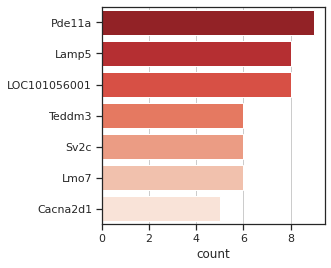

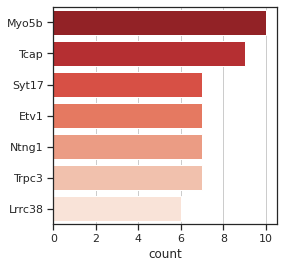

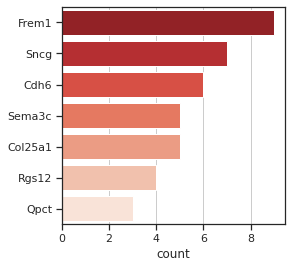

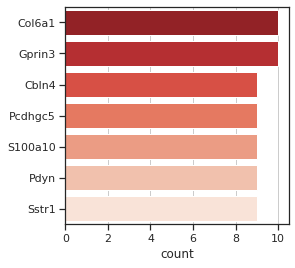

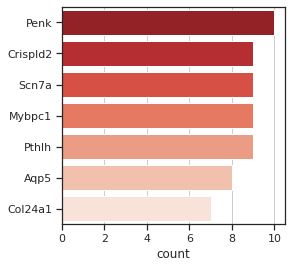

In [12]:
sub_numers = {'Lamp5':2, 'Pvalb':5, 'Sncg':2, 'Sst':13, 'Vip':5}
for ct in ['Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Vip']:
    fig,ax = plt.subplots(figsize=[4,4])
    ct_ct = pd.DataFrame(t_feature[ct])['feature_name'].value_counts().sort_values(ascending=False)
    x_order = ct_ct.index
    sns.countplot(data = t_feature[ct],y='feature_name',order = x_order[:thres],
                  palette='Reds_r',ax=ax)
    plt.grid(axis='x')
    # plt.title(f'{ct} (merged from {sub_numers[ct]} sub types)')
    # plt.xlim([0,10.5])
    plt.savefig(f'./shap_robustness/patchseq/type_relevance_{ct}_T_v2.pdf')
    type_feature_cv['T'][ct] = ct_ct[:thres].index.to_numpy()
    #type_feature_cv['T'][ct] = ct_ct[ct_ct.values>=thres].index.to_numpy()

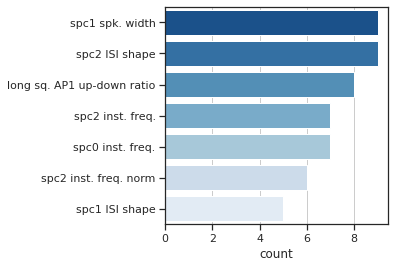

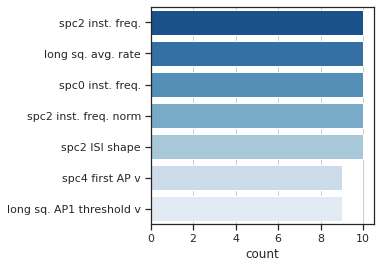

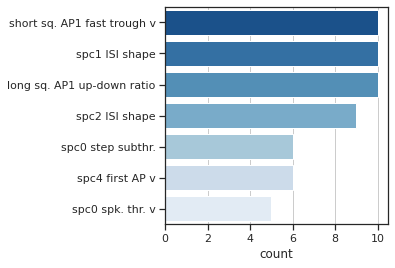

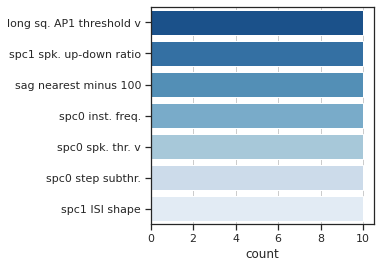

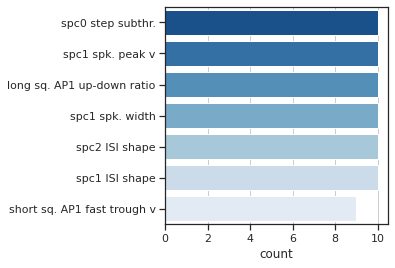

In [13]:
for ct in ['Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Vip']:
    fig,ax = plt.subplots(figsize=[4,4])
    ct_ct = pd.DataFrame(e_feature[ct])['feature_name'].value_counts().sort_values(ascending=False)
    x_order = ct_ct.index
    sns.countplot(data = e_feature[ct],y='feature_name',order = x_order[:thres],
                  palette='Blues_r',ax=ax)
    plt.grid(axis='x')
    # plt.title(ct)
    # plt.xlim([0,10.5])
    plt.savefig(f'./shap_robustness/patchseq/type_relevance_{ct}_E_v2.pdf')
    type_feature_cv['E'][ct] = ct_ct[:thres].index.to_numpy()
    #type_feature_cv['E'][ct] = ct_ct[ct_ct.values>=thres].index.to_numpy()

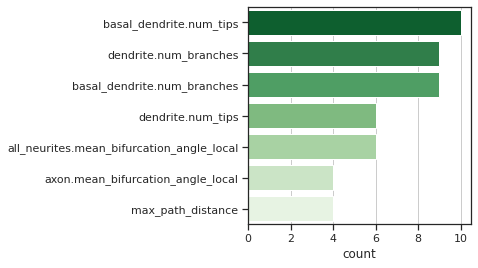

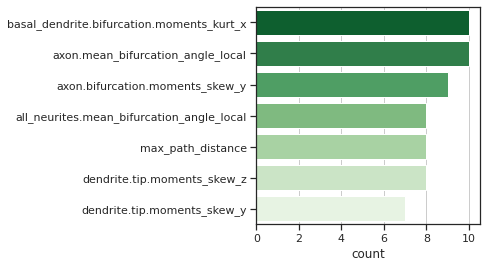

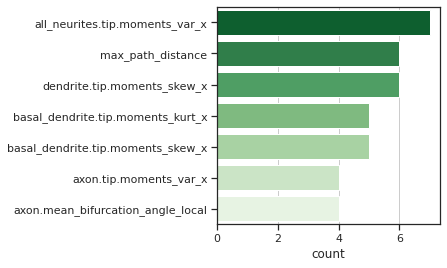

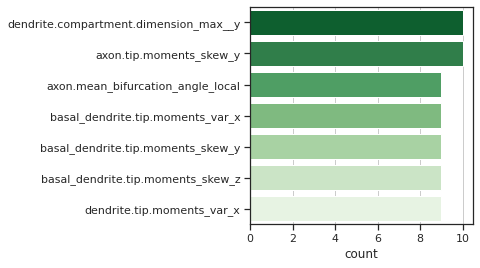

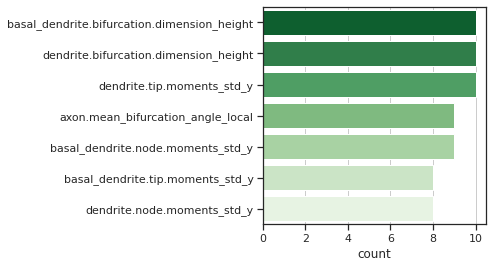

In [14]:

for ct in ['Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Vip']:
    fig,ax = plt.subplots(figsize=[4,4])
    ct_ct = pd.DataFrame(m_feature[ct])['feature_name'].value_counts().sort_values(ascending=False)
    x_order = ct_ct.index
    sns.countplot(data = m_feature[ct],y='feature_name',order = x_order[:thres],
                  palette='Greens_r',ax=ax)
    plt.grid(axis='x')
    # plt.title(ct)
    # plt.xlim([0,10.5])
    plt.savefig(f'./shap_robustness/patchseq/type_relevance_{ct}_M_v2.pdf')
    type_feature_cv['M'][ct] = ct_ct[:thres].index.to_numpy()
    # type_feature_cv['M'][ct] = ct_ct[ct_ct.values>=thres].index.to_numpy()

# Cross validated type-feature relevance plot

In [1]:
type_feature_shap_avg = []
for ct in range(27):
    ct_vl = []
    for mod in range(3):
        ct_mod_vl = []
        for cv in range(10):
            ct_mod_vl.append(type_feature_shap_values[cv][ct][mod])
        ct_vl.append(np.mean(ct_mod_vl,axis=0))
    type_feature_shap_avg.append(ct_vl)



In [15]:
for cv in range(1):
    print(f'++++++++++++++ the current cv is {cv} ++++++++++++++')
    root_save_path = f"./saved_results/{technique}_{cv}_n"
    model = UnitedNet(root_save_path, device=device, technique=patchseq_config)
    _,_,adatas_all = patch_seq_pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,ind_dict,split=False)

    model.load_model(f"{root_save_path}/train_best.pt",device=device)
    model.model.device_in_use = device
    losses = model.evaluate(adatas_all,give_losses=True,stage='train')
    predict_label = model.predict_label(adatas_all)
    adata_fused = model.infer(adatas_all)
    adata_fused.obs['label'] = list(adatas_all[0].obs['label'])
    adata_fused.obs['label_less'] = [ct.split('-')[0] for ct in adata_fused.obs['label'].values]


    pseudo_label = np.array(adata_fused.obs['predicted_label'].values)
    cmat = confusion_matrix(adata_fused.obs['label'], pseudo_label)
    ri, ci = linear_sum_assignment(-cmat)
    ordered_all = cmat[np.ix_(ri, ci)]
    major_sub_names = {}
    pred_labels_re_order = copy.deepcopy(pseudo_label)
    lb_cor_dict = {}
    for re_oder,(lb_correct,lb) in enumerate(zip(unique_labels(adata_fused.obs['label'], pseudo_label)[ri],
                                    unique_labels(adata_fused.obs['label'], pseudo_label)[ci])):
      idx = pseudo_label==lb
      if any(idx):
        nm = '-'.join(lb_correct.split('-')[:-1])
        if nm in major_sub_names.keys():
          major_sub_names[nm]+=1
        else:
          major_sub_names[nm]=1
        lb_cor_dict[lb]=lb_correct
        pred_labels_re_order[idx] = f'{nm}-{major_sub_names[nm]}-Uni'#f'{lb_correct}-Uni'#
        

    adata_fused.obs['predicted_label'] = pred_labels_re_order
    adata_fused.obs['predicted_label_less'] = [ct.split('-')[0] for ct in adata_fused.obs['predicted_label'].values]

    accuracy_matching.append([adjusted_rand_score(adata_fused.obs['label_less'], adata_fused.obs['predicted_label_less']),adjusted_rand_score(adata_fused.obs['label'], adata_fused.obs['predicted_label'])])


++++++++++++++ the current cv is 0 ++++++++++++++


Lamp5
['Pde11a' 'Lamp5' 'LOC101056001' 'Teddm3' 'Sv2c' 'Lmo7' 'Cacna2d1'
 'spc1 spk. width' 'spc2 ISI shape' 'long sq. AP1 up-down ratio'
 'spc2 inst. freq.' 'spc0 inst. freq.' 'spc2 inst. freq. norm'
 'spc1 ISI shape' 'basal_dendrite.num_tips' 'dendrite.num_branches'
 'basal_dendrite.num_branches' 'dendrite.num_tips'
 'all_neurites.mean_bifurcation_angle_local'
 'axon.mean_bifurcation_angle_local' 'max_path_distance' 'Lamp5-MET-2-Uni'
 'Lamp5-MET-1-Uni']
Pvalb
['Myo5b' 'Tcap' 'Syt17' 'Etv1' 'Ntng1' 'Trpc3' 'Lrrc38' 'spc2 inst. freq.'
 'long sq. avg. rate' 'spc0 inst. freq.' 'spc2 inst. freq. norm'
 'spc2 ISI shape' 'spc4 first AP v' 'long sq. AP1 threshold v'
 'basal_dendrite.bifurcation.moments_kurt_x'
 'axon.mean_bifurcation_angle_local' 'axon.bifurcation.moments_skew_y'
 'all_neurites.mean_bifurcation_angle_local' 'max_path_distance'
 'dendrite.tip.moments_skew_z' 'dendrite.tip.moments_skew_y'
 'Pvalb-MET-3-Uni' 'Pvalb-MET-2-Uni' 'Pvalb-MET-4-Uni' 'Pvalb-MET-5-Uni'
 'Pvalb-MET-1-Un

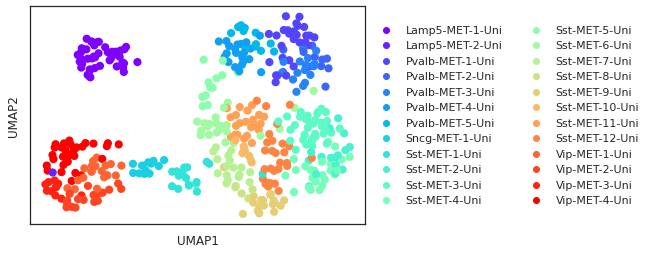

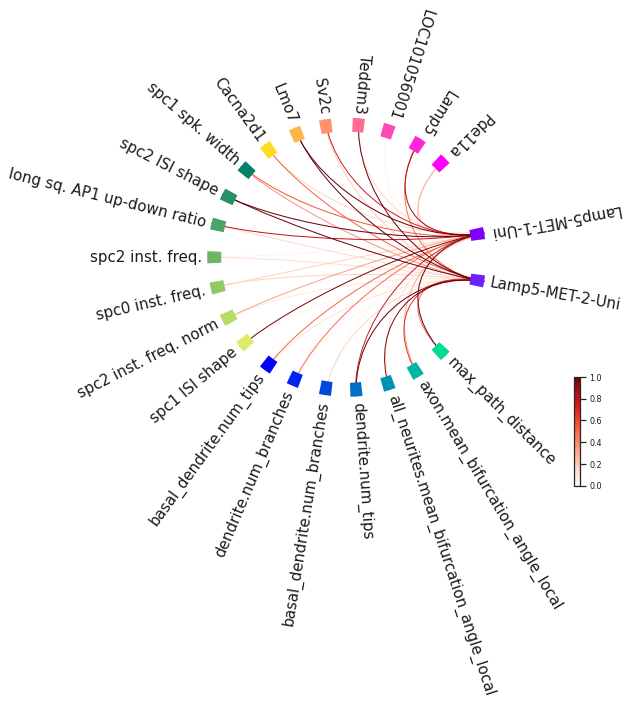

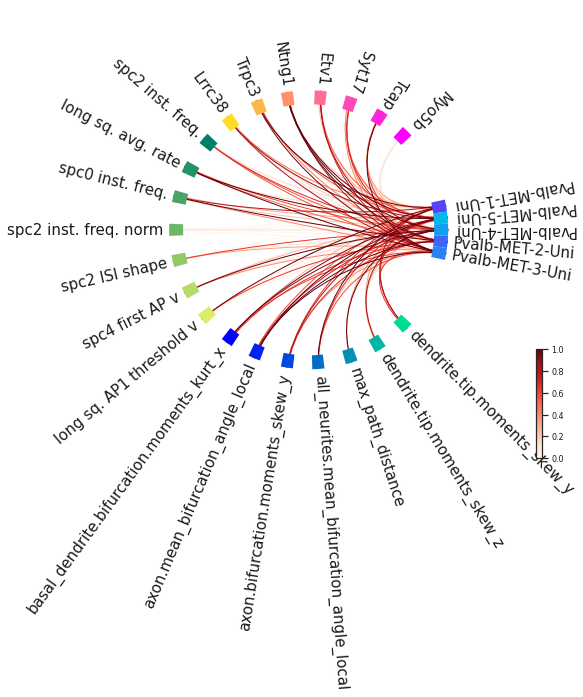

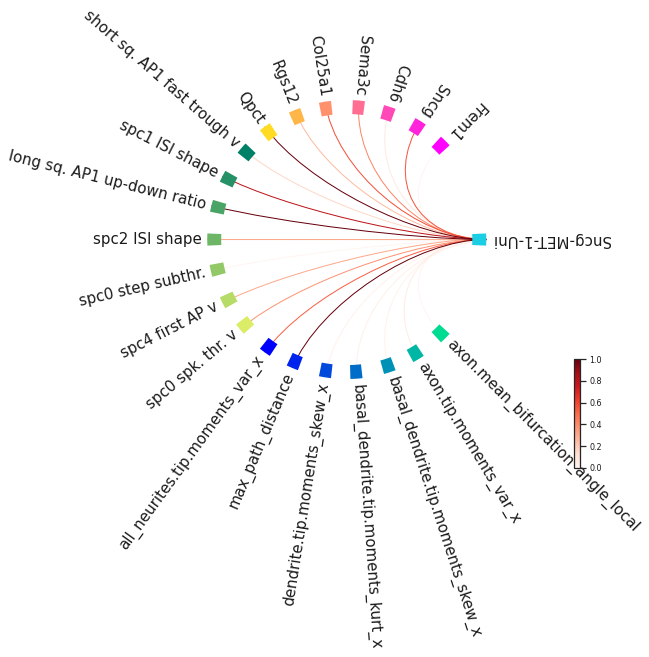

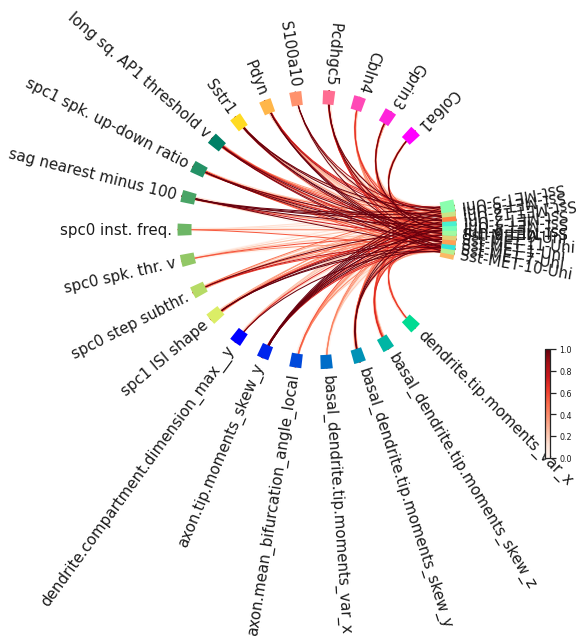

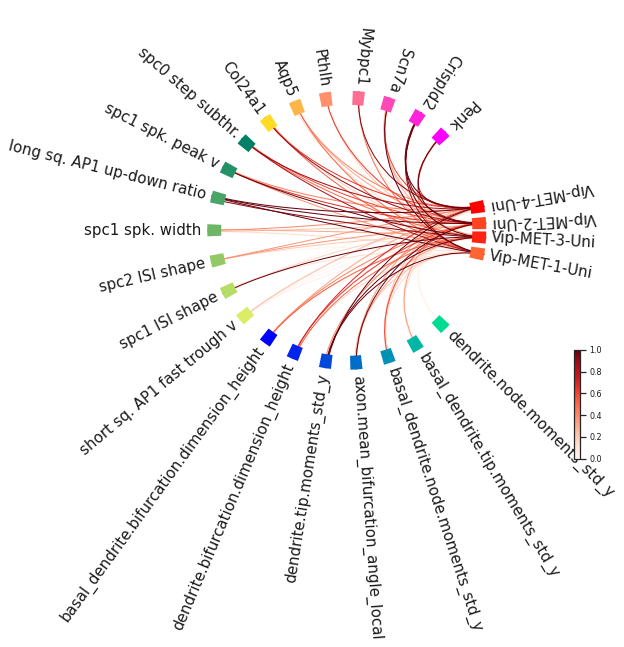

In [16]:
predict_label_sub = [ct.split('-')[0] for ct in adatas_all[0].obs['label']]

major_dict = dict(zip(adata_fused.obs['predicted_label'].values,adata_fused.obs['predicted_label_less'].values))
predict_label_anno = pred_labels_re_order


adatas_all_new,_,_,p_l_less,pr_ty_dict = markers_chord_plot(adatas_all,predict_label,predict_label_anno,major_dict)

# ct = 'Pvalb'
for ct in np.unique(p_l_less):
    p_fe = [type_feature_cv[mod][ct] for mod in ['T','E','M']]
    p_fe_idx = [np.in1d(adatas_all[i].var_names, p_fe[i]) for i in range(3)]


    all_less_type = [ct]#

    if 'predicted_label_colors' not in adata_fused.uns.keys():
        sc.pl.umap(adata_fused,color=['predicted_label'],palette='rainbow',show=False,title='')
    colors_type = dict(zip(adata_fused.obs['predicted_label'].cat.categories,adata_fused.uns['predicted_label_colors']))
    all_type_features = type_relevance_chord_plot(type_feature_shap_avg, p_fe, p_fe_idx, p_l_less,predict_label, colors_type, all_less_type,f'{technique}_{ct}_v3',
                                  pr_ty_dict,thres=0.0,only_show_good=True, linewidth=1, linecolormap='Reds', node_width=5,
                                  potential_coloarmaps=['spring', 'summer', 'winter', 'autumn'])



# load the average feature-to-feature relevance

In [17]:
with open('./saved_results/patch_seq_cross_feature_relevance_robust.pkl', 'rb') as handle:
    feature_relevance = pickle.load(handle)


In [18]:
feature_feature_shap_avg = {'0to1':[], '0to2':[]}
for f01 in range(68):
    f01_list = []
    for cv in range(10):
        f01_list.append(feature_relevance[cv]['0to1'][f01])
    feature_feature_shap_avg['0to1'].append(np.mean(f01_list,axis=0))
  

for f01 in range(514):
    f01_list = []
    for cv in range(10):
        f01_list.append(feature_relevance[cv]['0to2'][f01])
    feature_feature_shap_avg['0to2'].append(np.mean(f01_list,axis=0))



In [19]:
type_feature_cv_reorder = {}
for mod_idx, mod_nm in enumerate(type_feature_cv.keys()):
  for ctp in type_feature_cv[mod_nm].keys():
    if ctp not in type_feature_cv_reorder.keys():
      type_feature_cv_reorder[ctp] = {}
    type_feature_cv_reorder[ctp][mod_idx] = type_feature_cv[mod_nm][ctp]


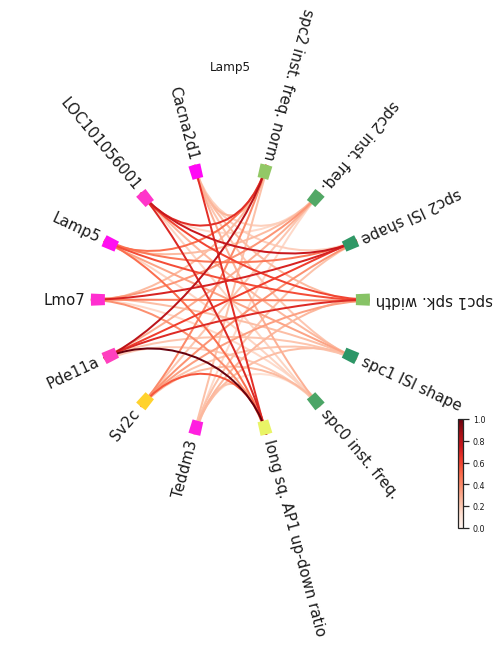

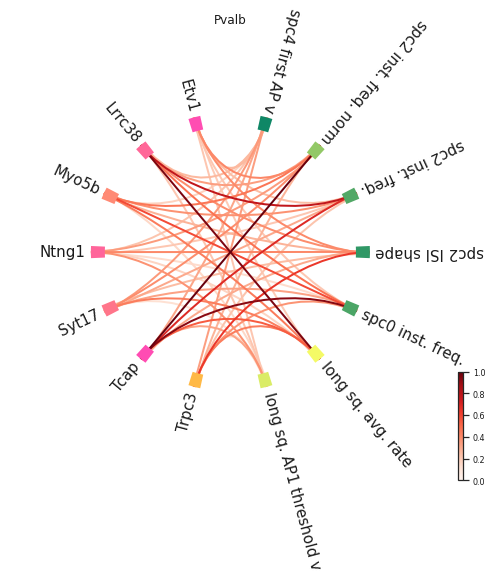

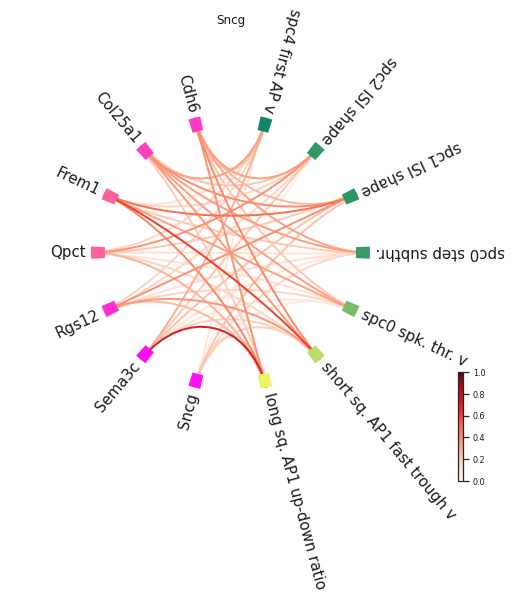

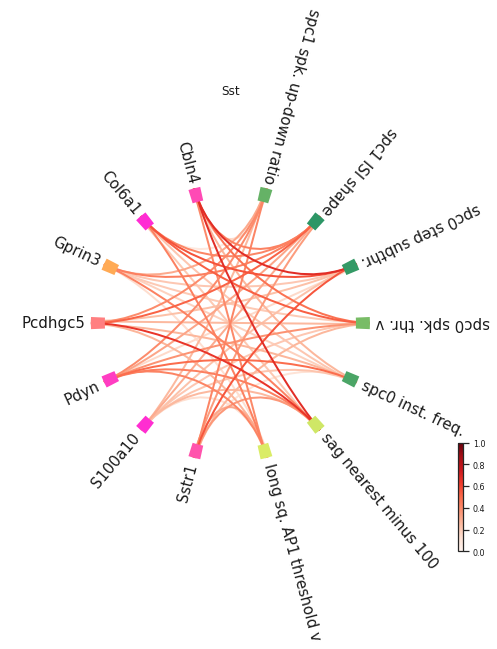

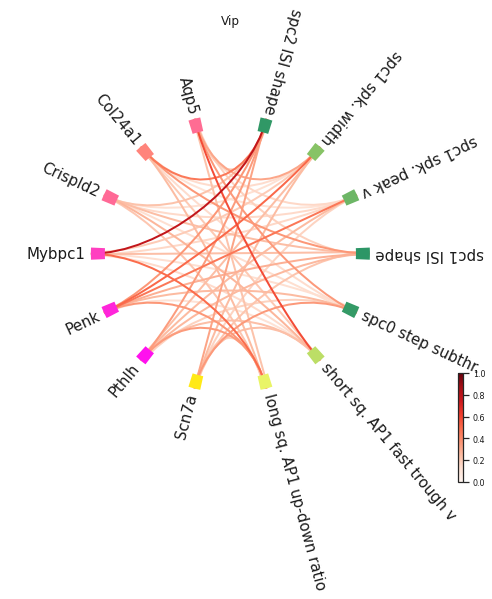

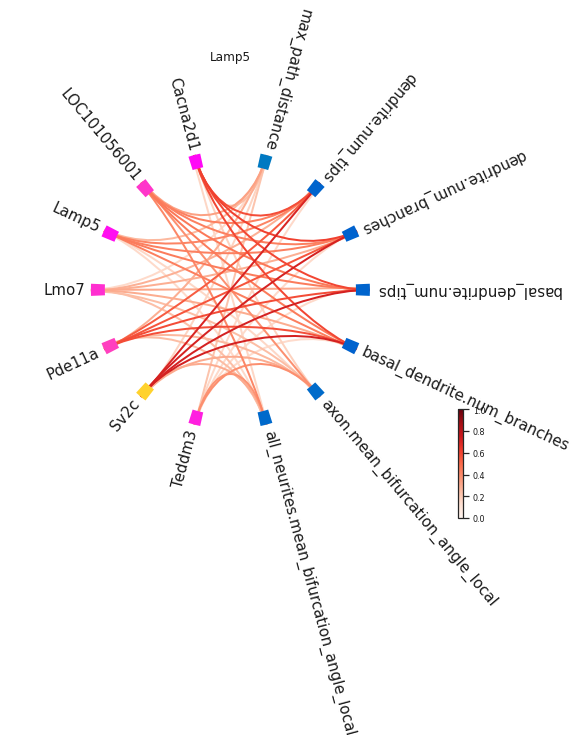

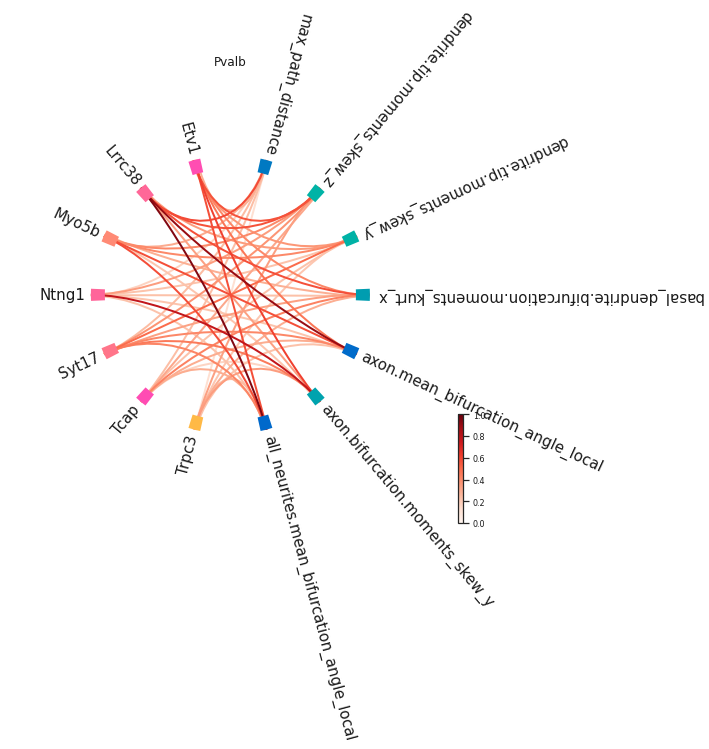

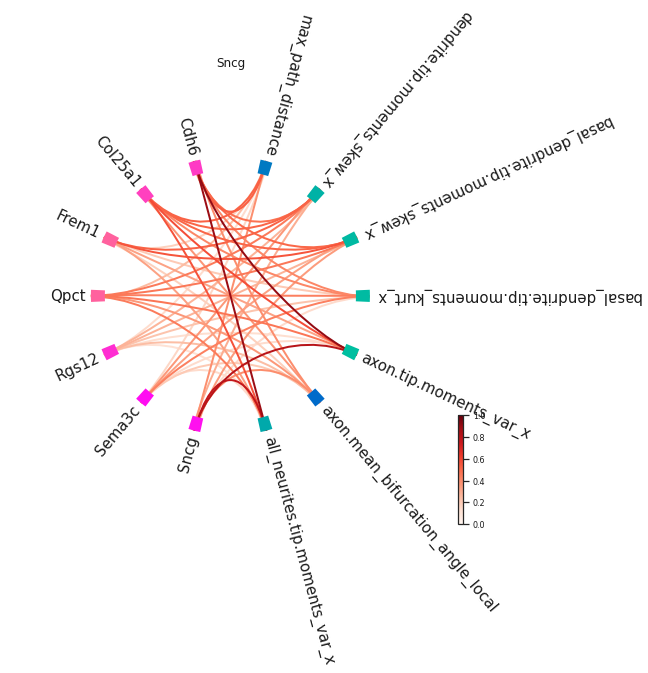

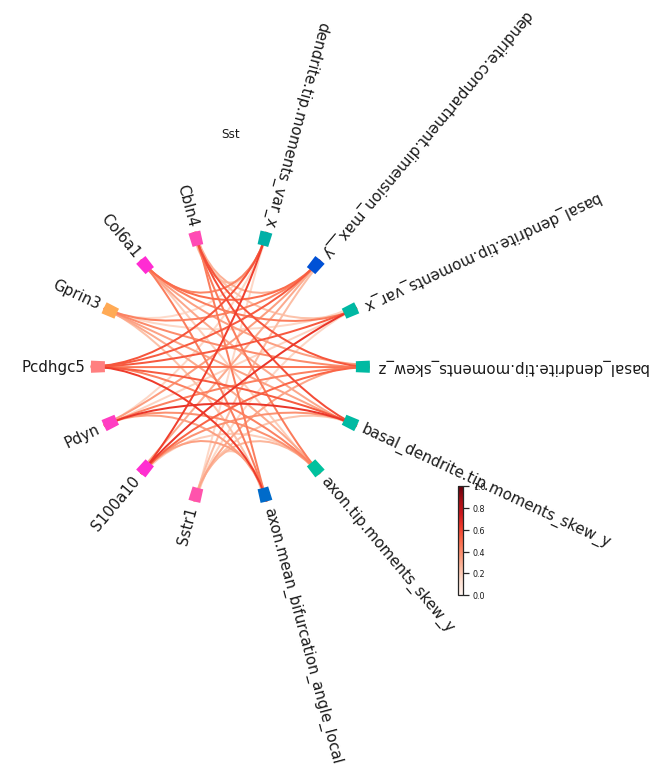

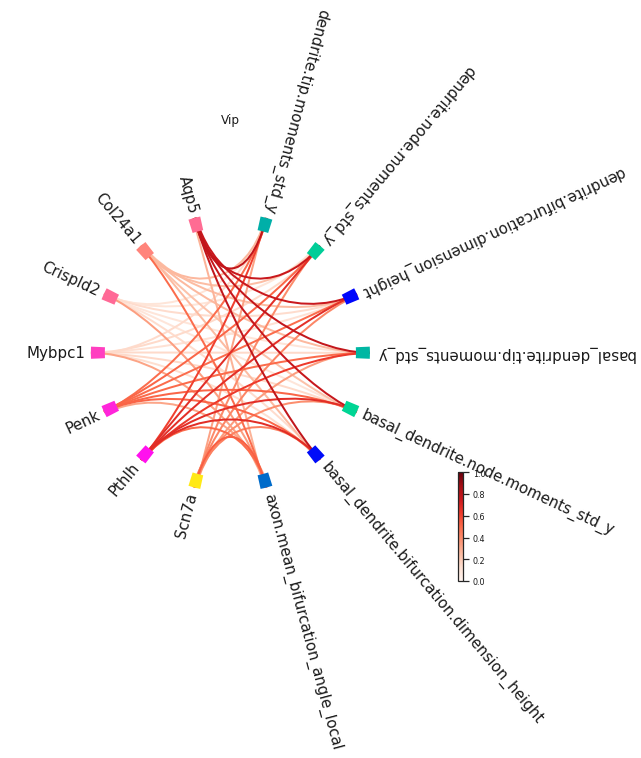

In [20]:

unique_ct = list(type_feature_cv_reorder.keys())

var_names_all = [ad.var_names.values for ad in adatas_all[:2]]
c_v_values_01, io_names_01 = feature_relevance_chord_plot(feature_feature_shap_avg['0to1'],unique_ct,var_names_all,type_feature_cv_reorder,f'{technique}_cv_{cv}_average_v3',in_mod = 0,thres = None,
                                potential_coloarmaps=['spring', 'summer', 'winter', 'autumn'])

var_names_all = [ad.var_names.values for ad in adatas_all[::2]]
c_v_values_02, io_names_02 = feature_relevance_chord_plot(feature_feature_shap_avg['0to2'],unique_ct,var_names_all,type_feature_cv_reorder,f'{technique}_cv_{cv}_average_v3',in_mod = 0,thres = None,
                            direction = '0to2',potential_coloarmaps=['spring', 'summer', 'winter', 'autumn'])


